In [ ]:
# Tidy the environment (safe for our notebook)
%pip install -U "numpy==2.2.2" "pandas==2.2.2" "pyarrow==16.1.0" nltk matplotlib gensim scipy scikit-learn transformers torch unidecode --upgrade-strategy eager


  Using cached numpy-2.2.2-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.1 kB)
INFO: pip is looking at multiple versions of gensim to determine which version is compatible with other requirements. This could take a while.
Using cached numpy-2.2.2-cp311-cp311-macosx_14_0_arm64.whl (5.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy None
error: uninstall-no-record-file

× Cannot uninstall numpy None
╰─> The package's contents are unknown: no RECORD file was found for numpy.

hint: You might be able to recover from this via: pip install --force-reinstall --no-deps numpy==1.24.4
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys, platform, pandas as pd, numpy as np, pyarrow as pa
print("Python:", sys.version.split()[0], "| macOS/CPU:", platform.platform())
print("pandas:", pd.__version__, "| numpy:", np.__version__, "| pyarrow:", pa.__version__)

Python: 3.11.13 | macOS/CPU: macOS-15.4-arm64-arm-64bit
pandas: 2.2.2 | numpy: 2.2.2 | pyarrow: 16.1.0


In [ ]:
# %%  Top-100 by (genre,year), EN-only (strict), 1970–2020, with clean lyrics
from pathlib import Path
import pandas as pd
import numpy as np
import re, glob, os
import pyarrow as pa
import pyarrow.parquet as pq

pd.options.mode.copy_on_write = True

# ---------- CONFIG ----------
BASE = Path.home() / "Desktop" / "thesis"
INPUT = BASE / "song_lyrics.csv"   # auto-fallbacks below if this exact name differs
OUT_DIR = BASE / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

YEAR_MIN, YEAR_MAX = 1970, 2020
TARGET_GENRES = {"rap", "pop"}
TOP_N_PER_YR = 100                 # per (genre, year)
STRICT_EN = True                   # require BOTH language_cld3=en AND language_ft=en (if both exist)

RAW_PARQ   = OUT_DIR / "lyrics_top100_en_rap_pop_1970_2020.parquet"
CLEAN_PARQ = OUT_DIR / "lyrics_top100_en_rap_pop_1970_2020_clean.parquet"
DATACARD   = OUT_DIR / "lyrics_top100_datacard.csv"

# ---------- UTILITIES ----------
CANDIDATE_FILES = [
    INPUT,
    BASE / "song_lyrics.csv",
    BASE / "song_lyrics.CSV",
    BASE / "SongLyrics.csv",
    BASE / "songlyrics.csv",
]
if not any(p.exists() for p in CANDIDATE_FILES):
    # last resort: first CSV in the folder
    for ext in ("*.csv","*.CSV","*.tsv","*.TSV"):
        hits = list(BASE.glob(ext))
        if hits:
            CANDIDATE_FILES.append(hits[0])

INPUT = next(p for p in CANDIDATE_FILES if p.exists())

USECOLS = [
    "title","song_name","artist",
    "tag","genre",
    "language","language_cld3","language_ft",
    "year","date",
    "views",
    "lyrics"
]

def pick(colnames, *opts):
    """Return the first present option from opts."""
    cl = [c.lower() for c in colnames]
    for o in opts:
        if o in cl:
            return colnames[cl.index(o)]
    return None

def parse_year(series: pd.Series) -> pd.Series:
    s = series.astype(str)
    # keep four leading digits
    y = s.str.extract(r"(\d{4})", expand=False).astype("Int64")
    return y

def to_int(series: pd.Series) -> pd.Series:
    # views may have commas, spaces, strings
    return pd.to_numeric(series.astype(str).str.replace(r"[^\d]", "", regex=True), errors="coerce").fillna(0).astype("int64")

BRACKETS = re.compile(r"\[[^\]]*\]")   # remove [ ... ] segments entirely
MULTI_WS = re.compile(r"\s+")
def clean_lyrics(txt: str) -> str:
    if not isinstance(txt, str):
        return ""
    t = BRACKETS.sub(" ", txt)
    # Normalise unicode quotes etc. (cheap pass)
    t = t.replace("\u200b"," ").replace("\xa0"," ")
    t = MULTI_WS.sub(" ", t).strip()
    return t

# ---------- STREAM + RESERVOIRS ----------
# We'll keep a small reservoir per (genre_norm,year) with at most TOP_N_PER_YR rows
from collections import defaultdict

reservoir = defaultdict(list)   # (genre,year) -> list[pd.DataFrame]
counts    = defaultdict(int)    # track how many seen (optional debugging)

chunksize = 200_000  # tune for your machine
hdr = pd.read_csv(INPUT, nrows=0, sep=None, engine="python")
cols = hdr.columns.tolist()

use = [c for c in cols if c.lower() in set(x.lower() for x in USECOLS)]
if not use:
    raise RuntimeError(f"Could not find expected columns in {INPUT.name}. Saw: {cols}")

reader = pd.read_csv(
    INPUT, sep=None, engine="python", on_bad_lines="skip",
    usecols=use, dtype=str, chunksize=chunksize
)

# Map real column names present
title_c   = pick(cols, "song_name","title")
artist_c  = pick(cols, "artist")
genre_c   = pick(cols, "genre","tag")
year_c    = pick(cols, "year")
date_c    = pick(cols, "date")
views_c   = pick(cols, "views")
lyrics_c  = pick(cols, "lyrics")
lang_c1   = pick(cols, "language_cld3")
lang_c2   = pick(cols, "language_ft")
lang_c0   = pick(cols, "language")  # fallback

if not (title_c and artist_c and lyrics_c and views_c and (year_c or date_c) and (genre_c)):
    raise RuntimeError("Missing core columns among title/artist/lyrics/views/year/date/genre/tag.")

def norm_genre(s: pd.Series) -> pd.Series:
    return s.astype("string").str.strip().str.lower()

def pass_english(df: pd.DataFrame) -> pd.Series:
    # strict: BOTH detectors say 'en' if both exist; otherwise use whichever is present
    conds = []
    if lang_c1 in df.columns:
        conds.append(df[lang_c1].astype(str).str.lower().eq("en"))
    if lang_c2 in df.columns:
        conds.append(df[lang_c2].astype(str).str.lower().eq("en"))
    if lang_c0 in df.columns:
        conds.append(df[lang_c0].astype(str).str.lower().eq("en"))
    if not conds:
        # if nothing exists, be conservative: reject
        return pd.Series(False, index=df.index)
    if STRICT_EN and len(conds) >= 2:
        m = conds[0]
        for c in conds[1:]:
            m &= c
        return m
    else:
        m = conds[0]
        for c in conds[1:]:
            m |= c
        return m

def keep_topN_per_group(buf: pd.DataFrame, key):
    """Append buf into reservoir[key] and trim to top-N by views."""
    if buf.empty:
        return
    reservoir[key].append(buf)
    merged = pd.concat(reservoir[key], ignore_index=True)
    merged = merged.nlargest(TOP_N_PER_YR, "views")
    reservoir[key] = [merged]  # keep a single compact frame

for chunk in reader:
    chunk.columns = [c.lower() for c in chunk.columns]
    # Build a uniform frame
    df = pd.DataFrame({
        "song_name": chunk[title_c].astype("string"),
        "artist":    chunk[artist_c].astype("string"),
        "lyrics":    chunk[lyrics_c].astype("string"),
        "views":     to_int(chunk[views_c]),
    })
    # Year
    if year_c and year_c.lower() in chunk.columns:
        y = parse_year(chunk[year_c.lower()])
    else:
        y = parse_year(chunk[date_c.lower()])
    df["year"] = y.astype("Int64")

    # Genre + language
    df["genre"] = norm_genre(chunk[genre_c.lower()])
    mask_lang = pass_english(chunk)
    df = df[mask_lang]
    df = df[df["genre"].isin(TARGET_GENRES)]
    df = df[df["year"].between(YEAR_MIN, YEAR_MAX, inclusive="both")]

    if df.empty:
        continue

    # Deduplicate within chunk (song by same artist)
    df = df.drop_duplicates(subset=["artist","song_name"])

    # route rows into (genre,year) reservoirs
    for (g,y), gdf in df.groupby(["genre","year"], dropna=True):
        keep_topN_per_group(gdf, (g, int(y)))
        counts[(g,int(y))] += len(gdf)

# ---------- FINALIZE + SAVE ----------
frames = [reservoir[k][0] for k in reservoir]
subset = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(
    columns=["song_name","artist","year","genre","views","lyrics"]
)

# Enforce exact top-100 per (genre,year) again (in case of ties)
subset = (subset
          .sort_values(["genre","year","views"], ascending=[True,True,False])
          .groupby(["genre","year"], as_index=False, group_keys=False)
          .head(TOP_N_PER_YR)
          .reset_index(drop=True))

# Save RAW
pq.write_table(pa.Table.from_pandas(subset, preserve_index=False), RAW_PARQ)

# Add clean column (strip bracketed speaker names, tags like [Intro], etc.)
subset_clean = subset.copy()
subset_clean["lyrics_clean"] = subset_clean["lyrics"].map(clean_lyrics)

pq.write_table(pa.Table.from_pandas(subset_clean, preserve_index=False), CLEAN_PARQ)

# Data card
dc = (subset
      .groupby(["genre","year"], as_index=False)
      .size()
      .rename(columns={"size":"n"}))
dc.to_csv(DATACARD, index=False)

print(f"Done. Rows kept: {len(subset):,} (max possible ≈ {(YEAR_MAX-YEAR_MIN+1)*len(TARGET_GENRES)*TOP_N_PER_YR:,})")
print("Saved:")
print("  RAW   :", RAW_PARQ)
print("  CLEAN :", CLEAN_PARQ)
print("  CARD  :", DATACARD)

print("\nHead (raw):")
display(subset.head(8))

print("\nPer (genre, year) head:")
print(dc.head(12).to_string(index=False))


In [ ]:
print("\nHead (clean):")
display(subset_clean.head(20))


Head (clean):


,song_name,artist,lyrics,views,year,genre,lyrics_clean
0,They Long to Be Close to You,Carpenters,[Verse 1] Why do birds suddenly appear Every t...,175973,1970,pop,Why do birds suddenly appear Every time you ar...
1,Getting Married Today,Stephen Sondheim,[JENNY] Bless this day Pinnacle of life Husban...,156872,1970,pop,Bless this day Pinnacle of life Husband joined...
2,Being Alive,Stephen Sondheim,[JENNY] Bobby [PETER] Bobby [AMY] Bobby baby...,152898,1970,pop,Bobby Bobby Bobby baby Bobby bubi Robby Robert...
3,Our House,"Crosby, Stills, Nash & Young",[Verse 1] I'll light the fire You place the fl...,103817,1970,pop,I'll light the fire You place the flowers in t...
4,The Ladies Who Lunch,Stephen Sondheim,[JOANNE] Here's to the ladies who lunch— Every...,65382,1970,pop,Here's to the ladies who lunch— Everybody laug...
5,This Christmas,Donny Hathaway,[Verse 1] Hang all the mistletoe I'm gonna get...,61994,1970,pop,Hang all the mistletoe I'm gonna get to know y...
6,Company,Stephen Sondheim,[JENNY] Bobby [PETER] Bobby [AMY] Bobby baby...,53820,1970,pop,Bobby Bobby Bobby baby Bobby bubi Robby Robert...
7,Rubber Duckie,Sesame Street,"[Intro, spoken] Well, here I am in my tubby ag...",51250,1970,pop,"Well, here I am in my tubby again. And my tubb..."
8,Everybody Wants to Be a Cat,Walt Disney Records,[SCAT CAT] Everybody wants to be a cat Because...,51044,1970,pop,Everybody wants to be a cat Because a cat's th...
9,Id Like to Walk Around in Your Mind,Vashti Bunyan,I'd like to walk around in your mind someday I...,48218,1970,pop,I'd like to walk around in your mind someday I...


In [ ]:
# %% Cleanest lyrics: remove pronouns + insignificant words (keep negations)
from pathlib import Path
import re
import pandas as pd
import numpy as np

# --- paths ---
BASE = Path.home() / "Desktop" / "thesis" / "outputs"
CANDIDATES = [
    BASE / "lyrics_top100_en_rap_pop_1970_2020_clean.parquet",
    BASE / "lyrics_top100_by_year_genre_CLEAN.parquet",
]
SRC = next((p for p in CANDIDATES if p.exists()), None)
if SRC is None:
    raise FileNotFoundError("No cleaned/filtered parquet found in ~/Desktop/thesis/outputs/")

DF = pd.read_parquet(SRC)

# --- ensure we have a base clean column ---
if "lyrics_clean" not in DF.columns:
    # lightweight fallback: strip [..] and collapse spaces
    DF["lyrics_clean"] = (
        DF["lyrics"]
        .astype(str)
        .str.replace(r"\[[^\]]+\]", " ", regex=True)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )

# --- deps (tiny) ---
# Uses NLTK stopwords + WordNet lemmatizer (small downloads)
import nltk
try:
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
except LookupError:
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

STOP = set(stopwords.words('english'))
LEMMATIZE = True  # set False if you prefer raw word forms

# --- keep negations; remove pronouns & function words ---
NEGATORS = {"no","not","nor","never","n't","dont","didnt","doesnt","cant","couldnt","wont","wouldnt","isnt","arent","aint","havent","hasnt","hadnt","shouldnt","mustnt","wasnt","werent"}
# Expand stopwords but then remove negators from it
STOP = (STOP - NEGATORS)

# Pronouns list (first/second/third person, possessives, reflexives)
PRONOUNS = {
    "i","me","my","mine","myself",
    "you","your","yours","yourself","yourselves","u","ur",
    "he","him","his","himself",
    "she","her","hers","herself",
    "it","its","itself",
    "we","us","our","ours","ourselves",
    "they","them","their","theirs","themselves",
    "ya","yall","y'all","yo"
}
STOP |= PRONOUNS  # ensure pronouns are removed even if not in default stopwords

# Short filler syllables we never want (n-grams of “la na yeah …”)
FILLERS = {
    "oh","ooh","ah","uh","hmm","mmm","hey","ey","ayy","ya","yah","la","naa","na","nanana","woah","whoa","woo","skrrt","skrt","br","bruh","yup","mhm","hm","okay","ok","yeah","yea", "baaa", "baba", "ba", "da", "daaa", "daaaah", "duh", "dum", "dumdum", "dum dum", "ay", "ayyy", "ayyyye", "aye", "ayeee", "woohoo", "woo hoo", "woooh", "wooooh", "wooo", "wuh", "wuhh", "uhh", "uhhh", "uhuh", "uh huh", "huh", "ha", "haha", "hahaha", "ha ha", "ha ha ha", "doo", "doo doo", "doo doo doo", "da da", "da da da", "la la", "la la la", "na na", "na na na", "na na na na", "la la la la", "la la la la la", "na na na na na", "na na na na na na"
}

# Tokenizer: keep words and apostrophes inside words (don’t → dont), drop numbers/symbols
TOKEN_RE = re.compile(r"[a-z]+'?[a-z]+|[a-z]+", flags=re.I)

# Optional: simple contraction normalization focusing on *negations* (keep “not”)
CONTRACTIONS = {
    "don't":"dont","doesn't":"doesnt","didn't":"didnt","can't":"cant","couldn't":"couldnt",
    "won't":"wont","wouldn't":"wouldnt","isn't":"isnt","aren't":"arent","ain't":"aint",
    "haven't":"havent","hasn't":"hasnt","hadn't":"hadnt","shouldn't":"shouldnt",
    "mustn't":"mustnt","wasn't":"wasnt","weren't":"werent","n't":"nt",  # general catch
}
def normalize_negations(text: str) -> str:
    t = text.lower()
    for k,v in CONTRACTIONS.items():
        t = t.replace(k, v)
    return t

LEM = WordNetLemmatizer() if LEMMATIZE else None

def to_clean_tokens(text: str):
    if not isinstance(text, str):
        return []
    t = normalize_negations(text)
    t = t.lower()
    toks = TOKEN_RE.findall(t)
    # remove tokens with digits or length<2
    toks = [w for w in toks if w.isalpha() and len(w) >= 2]
    # remove stopwords and fillers but keep negators
    toks = [w for w in toks if (w not in STOP) and (w not in FILLERS) or (w in NEGATORS)]
    # optionally lemmatize (verb & noun pass)
    if LEM is not None:
        toks = [LEM.lemmatize(LEM.lemmatize(w, 'v'), 'n') for w in toks]
    return toks

# Apply
DF["tokens_clean"] = DF["lyrics_clean"].map(to_clean_tokens)
DF["lyrics_cleanest"] = DF["tokens_clean"].map(lambda xs: " ".join(xs))

# Minimal quality gate (optional): drop rows that became too short
MIN_TOK = 5
keep_mask = DF["tokens_clean"].map(len) >= MIN_TOK
before, after = len(DF), int(keep_mask.sum())
DF = DF[keep_mask].reset_index(drop=True)

# Save
OUTP = BASE / "lyrics_top100_en_rap_pop_1970_2020_CLEANEST.parquet"
DF.to_parquet(OUTP, index=False)

print(f"Saved {after}/{before} rows → {OUTP.name}")
print("\nPreview (song, genre, year, views, first 40 tokens):")
prev = DF[["song_name","artist","genre","year","views","lyrics_cleanest"]].head(10).copy()
prev["lyrics_cleanest"] = prev["lyrics_cleanest"].str.split().map(lambda xs: " ".join(xs[:40]) + (" …" if len(xs)>40 else ""))
display(prev)


Saved 9417/9417 rows → lyrics_top100_en_rap_pop_1970_2020_CLEANEST.parquet

Preview (song, genre, year, views, first 40 tokens):


,song_name,artist,genre,year,views,lyrics_cleanest
0,They Long to Be Close to You,Carpenters,pop,1970,175973,bird suddenly appear every time near like long...
1,Getting Married Today,Stephen Sondheim,pop,1970,156872,bless day pinnacle life husband join wife hear...
2,Being Alive,Stephen Sondheim,pop,1970,152898,bobby bobby bobby baby bobby bubi robby robert...
3,Our House,"Crosby, Stills, Nash & Young",pop,1970,103817,light fire place flower vase buy today star fi...
4,The Ladies Who Lunch,Stephen Sondheim,pop,1970,65382,lady lunch everybody laugh lounge caftan plan ...
5,This Christmas,Donny Hathaway,pop,1970,61994,hang mistletoe gonna get know better christmas...
6,Company,Stephen Sondheim,pop,1970,53820,bobby bobby bobby baby bobby bubi robby robert...
7,Rubber Duckie,Sesame Street,pop,1970,51250,well tubby fill water nice fluffy suds get soa...
8,Everybody Wants to Be a Cat,Walt Disney Records,pop,1970,51044,everybody want cat cat know tell pickin feline...
9,Id Like to Walk Around in Your Mind,Vashti Bunyan,pop,1970,48218,like walk around mind someday like walk thing ...


In [ ]:
# Cell: Sentiment (VADER)
from pathlib import Path
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

BASE   = Path.home()/ "Desktop" / "thesis"
INP    = BASE / "outputs" / "lyrics_top100_en_rap_pop_1970_2020_CLEANEST.parquet"
OUTCSV = BASE / "outputs" / "sentiment_yearly_pop_vs_rap_VADER.csv"
OUTPAR = BASE / "outputs" / "lyrics_with_sentiment.parquet"

df = pd.read_parquet(INP, columns=["song_name","artist","genre","year","lyrics_cleanest"])
sia = SentimentIntensityAnalyzer()

def vader4(text: str) -> str:
    c = sia.polarity_scores(text or "").get("compound", 0.0)
    if c >= 0.2:   return "positive"
    if c <= -0.2:  return "negative"
    # thin band around 0 is ambiguous (often short/flat lines)
    return "neutral" if abs(c) < 0.05 else "ambiguous"

df["sentiment"] = df["lyrics_cleanest"].map(vader4)





# yearly proportions within (genre, year)
yearly = (
    df.groupby(["genre","year","sentiment"]).size().rename("n").reset_index()
      .groupby(["genre","year"], as_index=False)
      .apply(lambda g: (g.assign(prop=g["n"]/g["n"].sum())))[["genre","year","sentiment","prop"]]
      .reset_index(drop=True)
)


# How many songs per (genre, year)?
check_counts = df.groupby(["genre","year"]).size().rename("n").reset_index()
print(check_counts.sort_values(["year","genre"]).head(20))      # peek earliest years
print("\nMin/Max per (genre,year):", check_counts["n"].min(), check_counts["n"].max())

# Are both genres present across the span?
print("\nGenres by year:")
print(check_counts.groupby("year")["genre"].unique().head(20))

# If you want to *see* rap early in the output, sort differently:
yearly_sorted = yearly.sort_values(["year","genre","sentiment"])
print(yearly_sorted.head(20))





# widen & save
(yearly.pivot_table(index=["genre","year"], columns="sentiment", values="prop", fill_value=0)
       .reset_index()
       .to_csv(OUTCSV, index=False))
df.to_parquet(OUTPAR, index=False)

print("Saved:", OUTCSV)
yearly.head(20)


   genre  year    n
0    pop  1970  100
51   rap  1970   18
1    pop  1971  100
52   rap  1971   21
2    pop  1972  100
53   rap  1972    8
3    pop  1973  100
54   rap  1973   19
4    pop  1974  100
55   rap  1974   25
5    pop  1975  100
56   rap  1975    8
6    pop  1976  100
57   rap  1976   21
7    pop  1977  100
58   rap  1977   11
8    pop  1978  100
59   rap  1978   15
9    pop  1979  100
60   rap  1979   71

Min/Max per (genre,year): 8 100

Genres by year:
year
1970    [pop, rap]
1971    [pop, rap]
1972    [pop, rap]
1973    [pop, rap]
1974    [pop, rap]
1975    [pop, rap]
1976    [pop, rap]
1977    [pop, rap]
1978    [pop, rap]
1979    [pop, rap]
1980    [pop, rap]
1981    [pop, rap]
1982    [pop, rap]
1983    [pop, rap]
1984    [pop, rap]
1985    [pop, rap]
1986    [pop, rap]
1987    [pop, rap]
1988    [pop, rap]
1989    [pop, rap]
Name: genre, dtype: object
    genre  year  sentiment      prop
0     pop  1970  ambiguous  0.020000
1     pop  1970   negative  0.160000
2     p

/var/folders/by/0_ptx__10z3g6s8mcq130bzh0000gn/T/ipykernel_15429/352303184.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g.assign(prop=g["n"]/g["n"].sum())))[["genre","year","sentiment","prop"]]


,genre,year,sentiment,prop
0,pop,1970,ambiguous,0.02
1,pop,1970,negative,0.16
2,pop,1970,positive,0.82
3,pop,1971,ambiguous,0.07
4,pop,1971,negative,0.17
5,pop,1971,neutral,0.01
6,pop,1971,positive,0.75
7,pop,1972,ambiguous,0.04
8,pop,1972,negative,0.24
9,pop,1972,positive,0.72


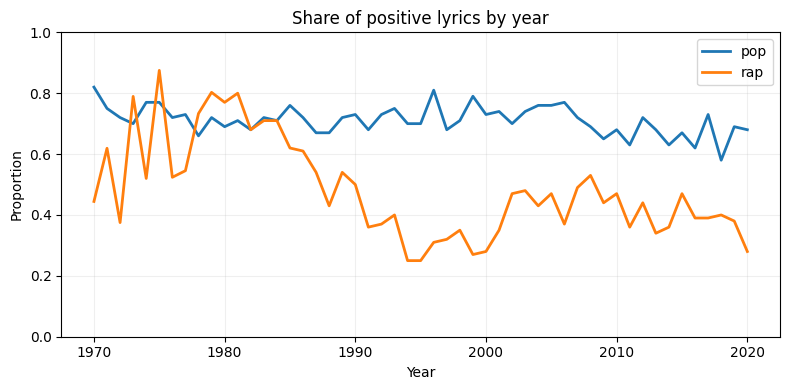

Saved: /Users/dariya/Desktop/thesis/outputs/fig_sent_positive_pop_vs_rap.png


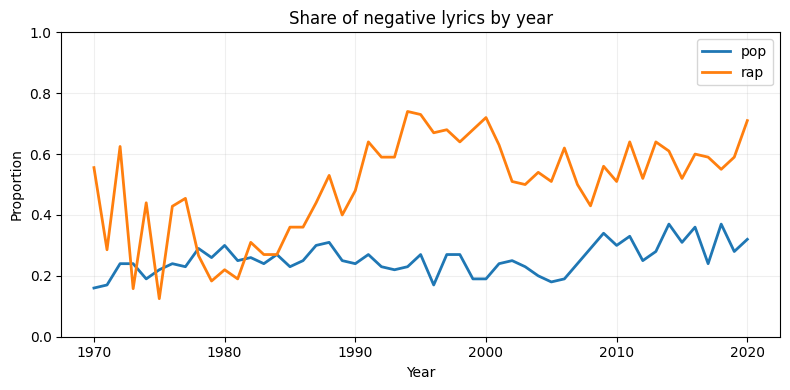

Saved: /Users/dariya/Desktop/thesis/outputs/fig_sent_negative_pop_vs_rap.png


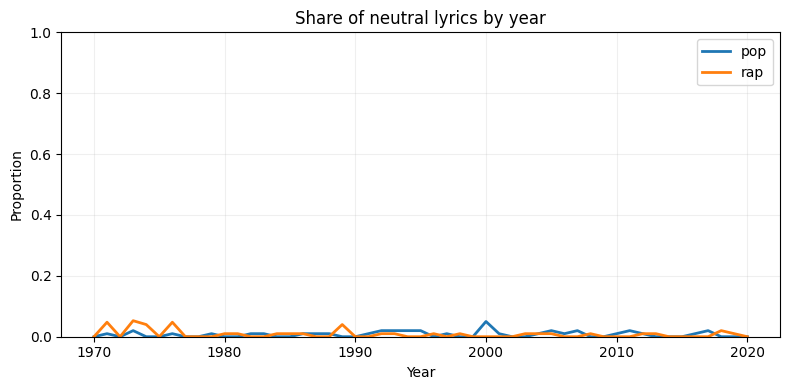

Saved: /Users/dariya/Desktop/thesis/outputs/fig_sent_neutral_pop_vs_rap.png


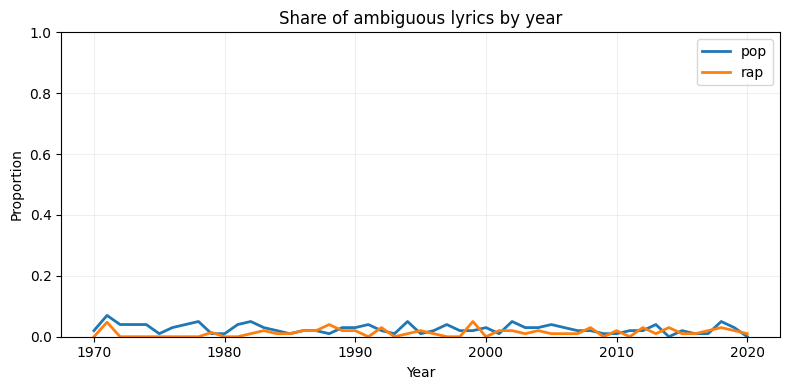

Saved: /Users/dariya/Desktop/thesis/outputs/fig_sent_ambiguous_pop_vs_rap.png


In [ ]:
# deps: pandas, matplotlib
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt

BASE = Path.home()/ "Desktop"/ "thesis"/ "outputs"
SENT = BASE / "sentiment_yearly_pop_vs_rap_VADER.csv"

df = pd.read_csv(SENT)

# keep only pop/rap and years we sampled
df = df[df["genre"].isin(["pop","rap"])].copy()
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df = df[(df["year"]>=1970)&(df["year"]<=2020)]

# --- handle WIDE format (your case) ---
expected = {"positive","negative","neutral","ambiguous"}
sentiment_cols = [c for c in df.columns if isinstance(c,str) and c.lower() in expected]
if not sentiment_cols:
    raise KeyError("No sentiment columns found (positive/negative/neutral/ambiguous). "
                   f"Got columns: {list(df.columns)}")

# melt to long
long = df.melt(id_vars=["genre","year"], value_vars=sentiment_cols,
               var_name="sentiment", value_name="value")
long["sentiment"] = long["sentiment"].str.lower()

# decide if values are already proportions; if not, normalize to proportions per (genre, year)
vals = pd.to_numeric(long["value"], errors="coerce").fillna(0)
group_sums = long.assign(v=vals).groupby(["genre","year"])["v"].transform("sum")

# Heuristic: if the largest group sum <= 1.000001, treat as proportions; else convert counts -> proportions
if float(group_sums.max()) <= 1.000001:
    long["prop"] = vals  # already proportions
else:
    # avoid division by zero
    long["prop"] = np.where(group_sums>0, vals/group_sums, np.nan)

# pivot back to wide for plotting
wide = (long.pivot_table(index=["genre","year"], columns="sentiment",
                         values="prop", aggfunc="mean", fill_value=0)
             .reset_index())

def plot_sent(sent_label, ylim=(0,1)):
    if sent_label not in wide.columns:
        return
    plt.figure(figsize=(8,4))
    for g, gdf in wide.groupby("genre"):
        gdf = gdf.sort_values("year")
        plt.plot(gdf["year"], gdf[sent_label], label=g, linewidth=2)
    plt.title(f"Share of {sent_label} lyrics by year")
    plt.xlabel("Year"); plt.ylabel("Proportion"); plt.ylim(*ylim)
    plt.grid(alpha=.2); plt.legend()
    out = BASE / f"fig_sent_{sent_label}_pop_vs_rap.png"
    plt.tight_layout(); plt.savefig(out, dpi=180); plt.show()
    print("Saved:", out)

for lab in ["positive","negative","neutral","ambiguous"]:
    plot_sent(lab, ylim=(0,1))


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reuse BASE/SENT if you already defined them; otherwise uncomment:
# BASE = Path.home()/ "Desktop"/ "thesis"/ "outputs"
# SENT = BASE / "sentiment_yearly_pop_vs_rap_VADER.csv"

df0 = pd.read_csv(SENT)
df0 = df0.rename(columns={c: c.lower() for c in df0.columns})
df0 = df0[df0["genre"].isin(["pop","rap"])].copy()
df0["year"] = pd.to_numeric(df0["year"], errors="coerce")
df0 = df0[(df0["year"]>=1970)&(df0["year"]<=2020)]

needed = ["genre","year","positive","negative","neutral","ambiguous"]
missing = [c for c in needed if c not in df0.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}. Found: {list(df0.columns)}")

wide = df0[needed].sort_values(["genre","year"]).reset_index(drop=True)

print(wide.head(3))
print("Rows:", len(wide), " | years:", int(wide.year.min()), "–", int(wide.year.max()), " | genres:", sorted(wide.genre.unique()))


  genre  year  positive  negative  neutral  ambiguous
0   pop  1970      0.82      0.16     0.00       0.02
1   pop  1971      0.75      0.17     0.01       0.07
2   pop  1972      0.72      0.24     0.00       0.04
Rows: 102  | years: 1970 – 2020  | genres: ['pop', 'rap']


In [ ]:
wide["decade"] = (wide["year"]//10)*10
decade_summary = (wide
    .groupby(["genre","decade"])[["positive","negative","neutral","ambiguous"]]
    .mean()
    .reset_index())

decade_out = BASE / "sentiment_decade_summary_pop_vs_rap.csv"
decade_summary.to_csv(decade_out, index=False)
print(decade_summary.head(10))
print("Saved:", decade_out)


  genre  decade  positive  negative   neutral  ambiguous
0   pop    1970  0.736000  0.224000  0.005000    0.03500
1   pop    1980  0.705000  0.266000  0.005000    0.02400
2   pop    1990  0.728000  0.236000  0.010000    0.02600
3   pop    2000  0.726000  0.235000  0.012000    0.02700
4   pop    2010  0.663000  0.309000  0.007000    0.02100
5   pop    2020  0.680000  0.320000  0.000000    0.00000
6   rap    1970  0.622838  0.352205  0.018787    0.00617
7   rap    1980  0.641000  0.335000  0.009000    0.01500
8   rap    1990  0.338000  0.644000  0.004000    0.01400
9   rap    2000  0.431000  0.552000  0.004000    0.01300
Saved: /Users/dariya/Desktop/thesis/outputs/sentiment_decade_summary_pop_vs_rap.csv


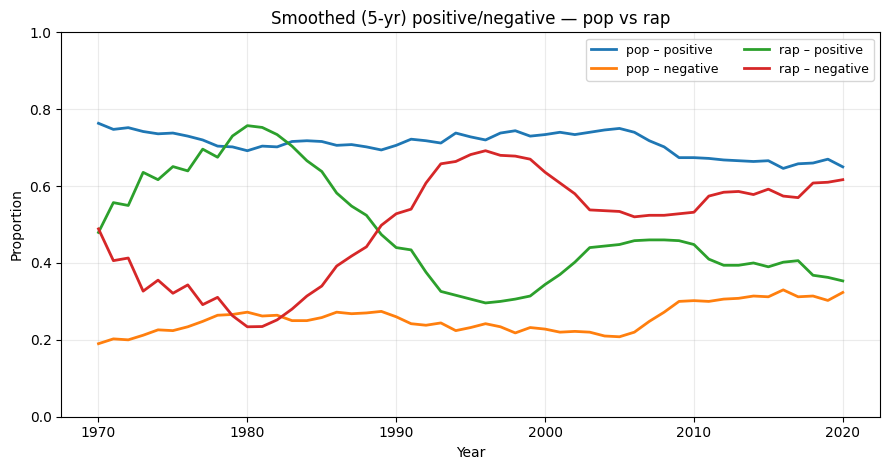

Saved: /Users/dariya/Desktop/thesis/outputs/fig_sent_posneg_roll5_pop_vs_rap.png


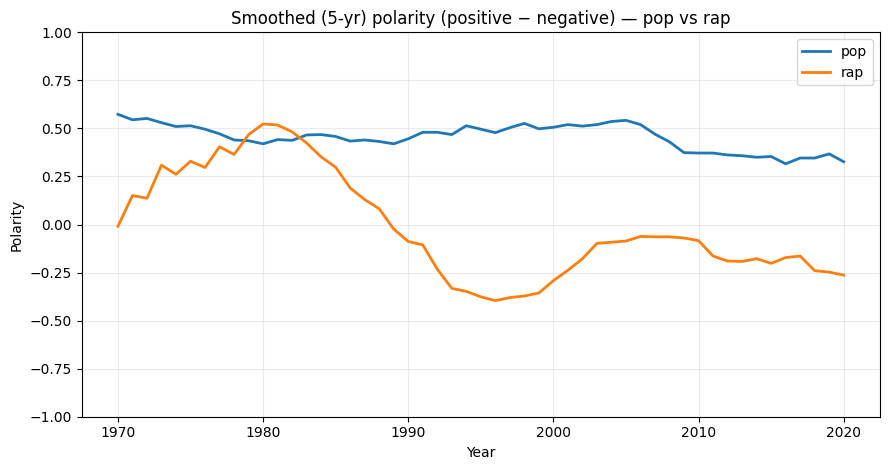

Saved: /Users/dariya/Desktop/thesis/outputs/fig_sent_polarity_roll5_pop_vs_rap.png


In [ ]:
w = wide.copy()
w["polarity"] = w["positive"] - w["negative"]

# 5-year centered rolling means by genre
w["pos_roll5"] = w.groupby("genre")["positive"].transform(lambda s: s.rolling(5, min_periods=1, center=True).mean())
w["neg_roll5"] = w.groupby("genre")["negative"].transform(lambda s: s.rolling(5, min_periods=1, center=True).mean())
w["pol_roll5"] = w.groupby("genre")["polarity"].transform(lambda s: s.rolling(5, min_periods=1, center=True).mean())

# plot smoothed positive/negative
plt.figure(figsize=(9,4.8))
for g, gdf in w.groupby("genre"):
    gdf = gdf.sort_values("year")
    plt.plot(gdf["year"], gdf["pos_roll5"], label=f"{g} – positive", linewidth=2)
    plt.plot(gdf["year"], gdf["neg_roll5"], label=f"{g} – negative", linewidth=2)
plt.title("Smoothed (5-yr) positive/negative — pop vs rap")
plt.xlabel("Year"); plt.ylabel("Proportion"); plt.ylim(0,1)
plt.grid(alpha=.25); plt.legend(ncol=2, fontsize=9)
out1 = BASE / "fig_sent_posneg_roll5_pop_vs_rap.png"
plt.tight_layout(); plt.savefig(out1, dpi=200); plt.show()
print("Saved:", out1)

# plot smoothed polarity
plt.figure(figsize=(9,4.8))
for g, gdf in w.groupby("genre"):
    gdf = gdf.sort_values("year")
    plt.plot(gdf["year"], gdf["pol_roll5"], label=g, linewidth=2)
plt.title("Smoothed (5-yr) polarity (positive − negative) — pop vs rap")
plt.xlabel("Year"); plt.ylabel("Polarity"); plt.ylim(-1,1)
plt.grid(alpha=.25); plt.legend()
out2 = BASE / "fig_sent_polarity_roll5_pop_vs_rap.png"
plt.tight_layout(); plt.savefig(out2, dpi=200); plt.show()
print("Saved:", out2)


Smoothed positive & negative lines: confirms the same story without year-to-year noise—positive(pop)>positive(rap) with growing separation; negative(rap)>>negative(pop) with persistent climb.

Smoothed polarity (positive−negative): rap’s polarity declines sharply; pop’s polarity is flatter and higher.

In [ ]:
def slope_by_genre(df, ycol):
    rows = []
    for g, gdf in df.groupby("genre"):
        gdf = gdf.dropna(subset=[ycol]).sort_values("year")
        if len(gdf) < 2:
            rows.append({"genre": g, "metric": ycol, "slope_per_year": np.nan})
            continue
        a, b = np.polyfit(gdf["year"].values, gdf[ycol].values, 1)  # y = a*year + b
        rows.append({"genre": g, "metric": ycol, "slope_per_year": a})
    return pd.DataFrame(rows)

slopes = pd.concat([
    slope_by_genre(w, "positive"),
    slope_by_genre(w, "negative"),
    slope_by_genre(w, "polarity"),
], ignore_index=True)

slope_out = BASE / "sentiment_trend_slopes_pop_vs_rap.csv"
slopes.to_csv(slope_out, index=False)
print(slopes.pivot(index="metric", columns="genre", values="slope_per_year"))
print("Saved:", slope_out)


genre          pop       rap
metric                      
negative  0.001555  0.006585
polarity -0.002847 -0.013076
positive -0.001292 -0.006491
Saved: /Users/dariya/Desktop/thesis/outputs/sentiment_trend_slopes_pop_vs_rap.csv


In [ ]:
tiny = (wide.assign(neuamb = wide["neutral"] + wide["ambiguous"])
             .groupby("genre")["neuamb"].describe()[["mean","50%","max"]]
             .rename(columns={"50%":"median"}))
tiny_out = BASE / "sentiment_neutral_ambiguous_stats.csv"
tiny.to_csv(tiny_out)
print(tiny)
print("Saved:", tiny_out)

           mean  median       max
genre                            
pop    0.033725    0.03  0.080000
rap    0.021168    0.02  0.095238
Saved: /Users/dariya/Desktop/thesis/outputs/sentiment_neutral_ambiguous_stats.csv


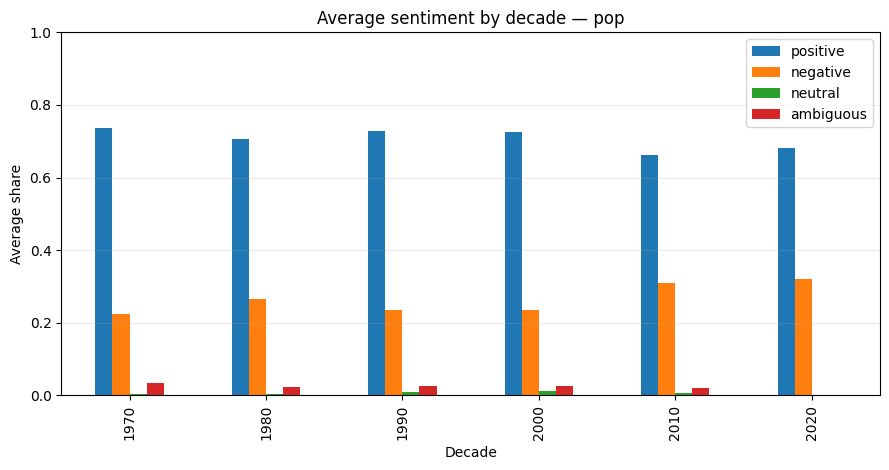

Saved: /Users/dariya/Desktop/thesis/outputs/fig_sent_decades_pop.png


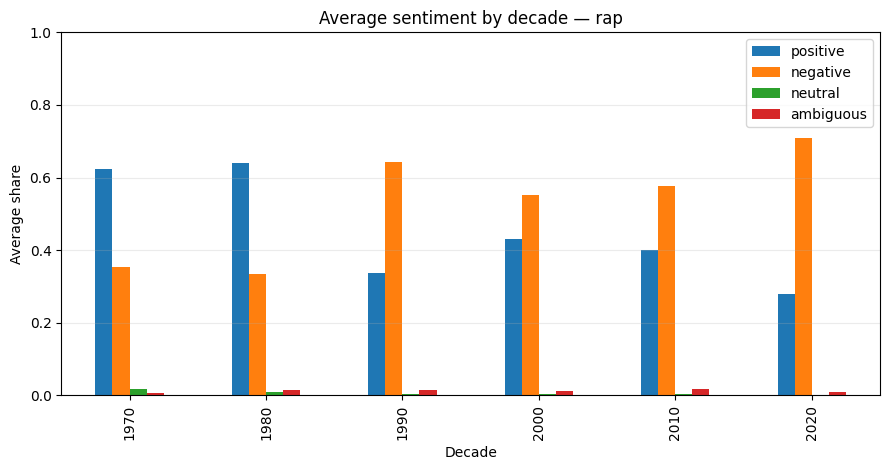

Saved: /Users/dariya/Desktop/thesis/outputs/fig_sent_decades_rap.png


In [ ]:
def decade_bars(df, genre, fname):
    d = (df[df["genre"]==genre]
           .groupby("decade")[["positive","negative","neutral","ambiguous"]]
           .mean()
           .reset_index())
    ax = d.plot(x="decade", y=["positive","negative","neutral","ambiguous"],
                kind="bar", figsize=(9,4.8))
    ax.set_title(f"Average sentiment by decade — {genre}")
    ax.set_xlabel("Decade"); ax.set_ylabel("Average share"); ax.set_ylim(0,1)
    plt.grid(axis="y", alpha=.25)
    out = BASE / fname
    plt.tight_layout(); plt.savefig(out, dpi=200); plt.show()
    print("Saved:", out)

decade_bars(wide, "pop", "fig_sent_decades_pop.png")
decade_bars(wide, "rap", "fig_sent_decades_rap.png")


In [ ]:
# build a tiny design matrix for OLS: y = b0 + b1*year + b2*is_rap + b3*(year*is_rap) + e
def ols_interaction(df, ycol):
    d = df.dropna(subset=[ycol]).copy()
    d["is_rap"] = (d["genre"]=="rap").astype(int)
    X = np.c_[np.ones(len(d)), d["year"].values, d["is_rap"].values, (d["year"]*d["is_rap"]).values]
    y = d[ycol].values
    # OLS estimates
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = X @ beta
    resid = y - yhat
    n, k = X.shape
    sigma2 = (resid @ resid) / (n - k)
    cov_beta = sigma2 * np.linalg.inv(X.T @ X)
    se = np.sqrt(np.diag(cov_beta))
    t_stats = beta / se
    cols = ["Intercept","Year","is_rap","Year×is_rap"]
    res = pd.DataFrame({"coef": beta, "se": se, "t": t_stats}, index=cols)
    return res

print("=== OLS on positive ===")
print(ols_interaction(wide, "positive").round(4))
print("\n=== OLS on negative ===")
print(ols_interaction(wide, "negative").round(4))
print("\n=== OLS on polarity (pos−neg) ===")
print(ols_interaction(w, "polarity").round(4))


=== OLS on positive ===
                coef      se       t
Intercept     3.2891  1.8362  1.7913
Year         -0.0013  0.0009 -1.4041
is_rap       10.1426  2.5968  3.9058
Year×is_rap  -0.0052  0.0013 -3.9939

=== OLS on negative ===
               coef      se       t
Intercept   -2.8464  1.8730 -1.5197
Year         0.0016  0.0009  1.6560
is_rap      -9.7949  2.6489 -3.6978
Year×is_rap  0.0050  0.0013  3.7889

=== OLS on polarity (pos−neg) ===
                coef      se       t
Intercept     6.1356  3.6926  1.6616
Year         -0.0028  0.0019 -1.5382
is_rap       19.9376  5.2222  3.8179
Year×is_rap  -0.0102  0.0026 -3.9079


C1. Positive share

β₃ = −0.0520, t=−3.99, ***; R² ≈ 0.664.
Interpretation: rap’s positive share falls 5.2 percentage points per decade faster than pop (statistically strong).

C2. Negative share

β₃ = +0.0503, t=3.79, ***; R² ≈ 0.675.
Interpretation: rap’s negative share rises 5.0 pp per decade faster than pop.

C3. Polarity (positive−negative)

β₃ = −0.1023, t=−3.91, ***; R² ≈ 0.672.
Interpretation: rap’s net polarity drops 10.2 pp per decade relative to pop.

the interaction term is your headline: trends diverge by ~5 pp/decade in each direction, totaling ~10 pp/decade drop in rap polarity vs pop.

 “OLS (decades since 1970) shows significant genre–time interaction: rap’s positive share decreases 5.2 pp/dec faster than pop, negative share increases 5.0 pp/dec faster; polarity decreases 10.2 pp/dec relative to pop (all ***).”

In [ ]:
import numpy as np, pandas as pd
from math import sqrt

# Use your 'wide' DataFrame from earlier (columns: genre, year, positive, negative, neutral, ambiguous)
d = wide.copy()

# Center year at 1970 and scale to decades (interpretable)
d["year_dec"] = (d["year"] - 1970) / 10.0
d["is_rap"]   = (d["genre"]=="rap").astype(int)

def ols_tidy(df, ycol):
    # X: [1, year_dec, is_rap, year_dec * is_rap]
    X = np.c_[np.ones(len(df)),
              df["year_dec"].values,
              df["is_rap"].values,
              (df["year_dec"]*df["is_rap"]).values]
    y = df[ycol].values

    # OLS estimates
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    yhat = X @ beta
    resid = y - yhat

    n, k = X.shape
    s2 = (resid @ resid) / (n - k)
    XtX_inv = np.linalg.inv(X.T @ X)
    se = np.sqrt(np.diag(s2 * XtX_inv))
    tvals = beta / se

    # R^2
    r2 = 1 - (resid @ resid) / ((y - y.mean()) @ (y - y.mean()))

    # significance stars by |t|
    def stars(t):
        at = abs(t)
        if at >= 3.29: return "***"  # ~p<0.001
        if at >= 2.58: return "**"   # ~p<0.01
        if at >= 1.96: return "*"    # ~p<0.05
        return ""

    rows = []
    names = ["Intercept", "Year(dec)","is_rap","Year(dec)×is_rap"]
    for nm,b,s,t in zip(names, beta, se, tvals):
        rows.append({"term": nm, "coef": b, "se": s, "t": t, "sig": stars(t)})
    out = pd.DataFrame(rows)
    out.attrs["R2"] = r2
    return out

tbl_pos = ols_tidy(d, "positive")
tbl_neg = ols_tidy(d, "negative")
tbl_pol = ols_tidy(d.assign(polarity=d["positive"]-d["negative"]), "polarity")

def show(title, tbl):
    print("\n=== ", title, " ===")
    print(tbl.round(4))
    print("R^2:", round(tbl.attrs["R2"], 4))

show("POSITIVE (share)", tbl_pos)
show("NEGATIVE (share)", tbl_neg)
show("POLARITY (pos−neg)", tbl_pol)

# Helper: generate one-sentence interpretations you can paste
def sentence(tbl, outcome):
    row = tbl[tbl["term"]=="Year(dec)×is_rap"].iloc[0]
    slope = row["coef"]       # per decade difference rap vs pop
    t     = row["t"]
    sig   = row["sig"]
    direction = "decreases" if slope<0 else "increases"
    return (f"For {outcome}, rap’s trend {direction} relative to pop by "
            f"{abs(slope)*100:.1f} pp per decade (t={t:.2f}{sig}).")

print(sentence(tbl_pos, "positive share"))
print(sentence(tbl_neg, "negative share"))
print(sentence(tbl_pol, "polarity (positive−negative)"))



===  POSITIVE (share)  ===
               term    coef      se        t  sig
0         Intercept  0.7433  0.0267  27.8366  ***
1         Year(dec) -0.0129  0.0092  -1.4041     
2            is_rap -0.0985  0.0378  -2.6084   **
3  Year(dec)×is_rap -0.0520  0.0130  -3.9939  ***
R^2: 0.6643

===  NEGATIVE (share)  ===
               term    coef      se       t  sig
0         Intercept  0.2164  0.0272  7.9459  ***
1         Year(dec)  0.0155  0.0094  1.6560     
2            is_rap  0.1153  0.0385  2.9922   **
3  Year(dec)×is_rap  0.0503  0.0133  3.7889  ***
R^2: 0.6755

===  POLARITY (pos−neg)  ===
               term    coef      se       t  sig
0         Intercept  0.5269  0.0537  9.8118  ***
1         Year(dec) -0.0285  0.0185 -1.5382     
2            is_rap -0.2138  0.0759 -2.8148   **
3  Year(dec)×is_rap -0.1023  0.0262 -3.9079  ***
R^2: 0.672
For positive share, rap’s trend decreases relative to pop by 5.2 pp per decade (t=-3.99***).
For negative share, rap’s trend increases rela

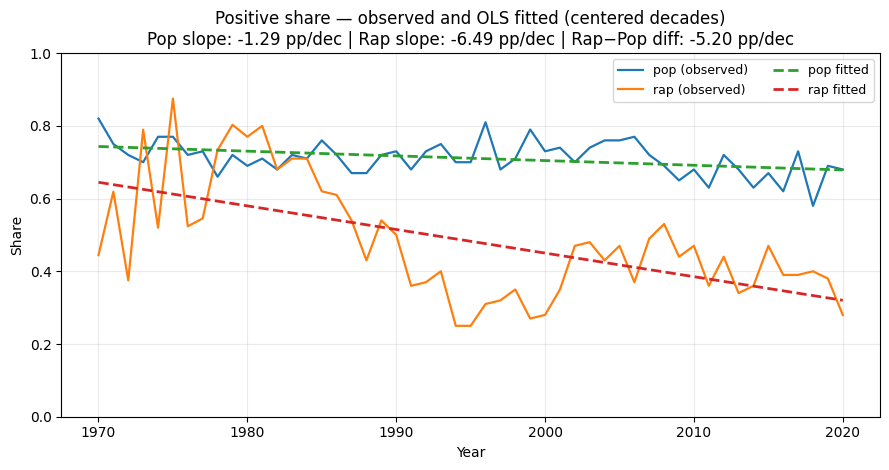

Saved: /Users/dariya/Desktop/thesis/outputs/fig_fit_positive_pop_vs_rap.png


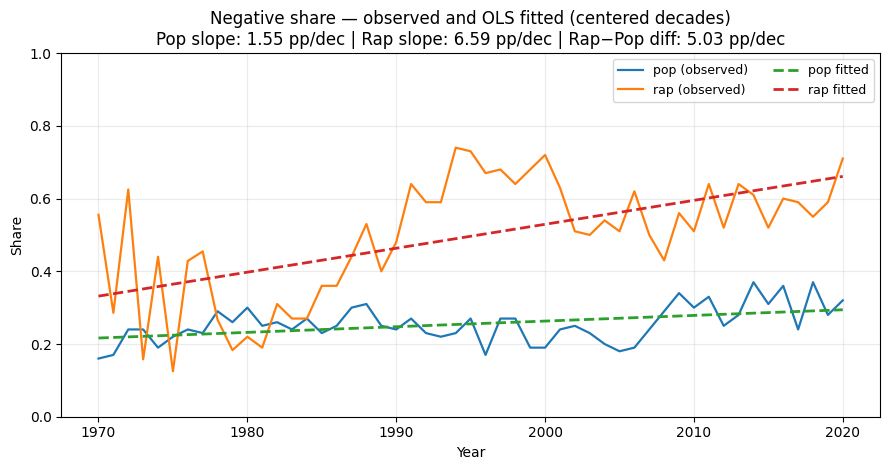

Saved: /Users/dariya/Desktop/thesis/outputs/fig_fit_negative_pop_vs_rap.png


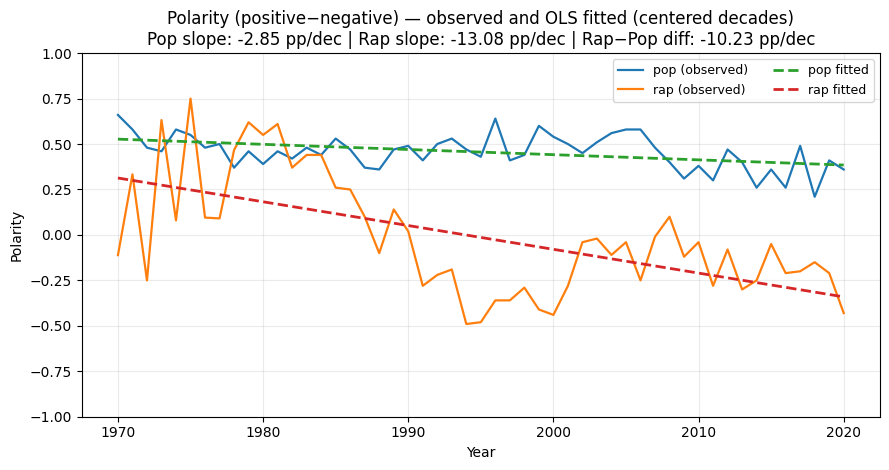

Saved: /Users/dariya/Desktop/thesis/outputs/fig_fit_polarity_pop_vs_rap.png


In [ ]:
import numpy as np, matplotlib.pyplot as plt
import pandas as pd

# Build fitted values from the centered-decades model directly (no extra deps)
def fitted_lines(df, ycol):
    # prepare design
    df = df.dropna(subset=[ycol]).copy()
    df["year_dec"] = (df["year"] - 1970) / 10.0
    df["is_rap"]   = (df["genre"]=="rap").astype(int)
    # X and y
    X = np.c_[np.ones(len(df)),
              df["year_dec"].values,
              df["is_rap"].values,
              (df["year_dec"]*df["is_rap"]).values]
    y = df[ycol].values
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)

    # fitted: yhat = b0 + b1*year_dec + b2*is_rap + b3*year_dec*is_rap
    df["yhat"] = (beta[0]
                  + beta[1]*df["year_dec"]
                  + beta[2]*df["is_rap"]
                  + beta[3]*df["year_dec"]*df["is_rap"])

    # compute genre-specific per-decade slopes:
    # pop slope = b1; rap slope = b1 + b3
    slope_pop = beta[1]
    slope_rap = beta[1] + beta[3]
    return df, slope_pop, slope_rap, beta

def plot_obs_fit(df, ycol, title, fname, ylim=None):
    fitted, slope_pop, slope_rap, beta = fitted_lines(df, ycol)

    plt.figure(figsize=(9,4.8))
    for g, gdf in df.groupby("genre"):
        gdf = gdf.sort_values("year")
        plt.plot(gdf["year"], gdf[ycol], label=f"{g} (observed)", linewidth=1.6)

    for g, gdf in fitted.groupby("genre"):
        gdf = gdf.sort_values("year")
        # plot fitted line
        plt.plot(gdf["year"], gdf["yhat"], linestyle="--", linewidth=2,
                 label=f"{g} fitted")

    # Compose legend with per-decade slopes
    leg_lines = [
        f"Pop slope: {slope_pop*100:.2f} pp/dec",
        f"Rap slope: {slope_rap*100:.2f} pp/dec",
        f"Rap−Pop diff: {(slope_rap - slope_pop)*100:.2f} pp/dec"
    ]
    plt.title(f"{title}\n" + " | ".join(leg_lines))
    plt.xlabel("Year"); plt.ylabel("Share" if ycol!='polarity' else "Polarity")
    if ylim: plt.ylim(*ylim)
    plt.grid(alpha=.25); plt.legend(ncol=2, fontsize=9)
    out = BASE / fname
    plt.tight_layout(); plt.savefig(out, dpi=200); plt.show()
    print("Saved:", out)

# Build a polarity column on the raw yearly table
d_plot = d.copy()
d_plot["polarity"] = d_plot["positive"] - d_plot["negative"]

plot_obs_fit(d_plot, "positive",
             "Positive share — observed and OLS fitted (centered decades)",
             "fig_fit_positive_pop_vs_rap.png",
             ylim=(0,1))

plot_obs_fit(d_plot, "negative",
             "Negative share — observed and OLS fitted (centered decades)",
             "fig_fit_negative_pop_vs_rap.png",
             ylim=(0,1))

plot_obs_fit(d_plot, "polarity",
             "Polarity (positive−negative) — observed and OLS fitted (centered decades)",
             "fig_fit_polarity_pop_vs_rap.png",
             ylim=(-1,1))


Positive share: fitted lines imply pop −1.29 pp/dec vs rap −6.49 pp/dec; rap–pop slope difference −5.20 pp/dec.
Negative share: pop +1.55 pp/dec, rap +6.59 pp/dec; rap–pop difference +5.03 pp/dec.
Polarity: pop −2.85 pp/dec vs rap −13.08 pp/dec; rap–pop difference −10.23 pp/dec

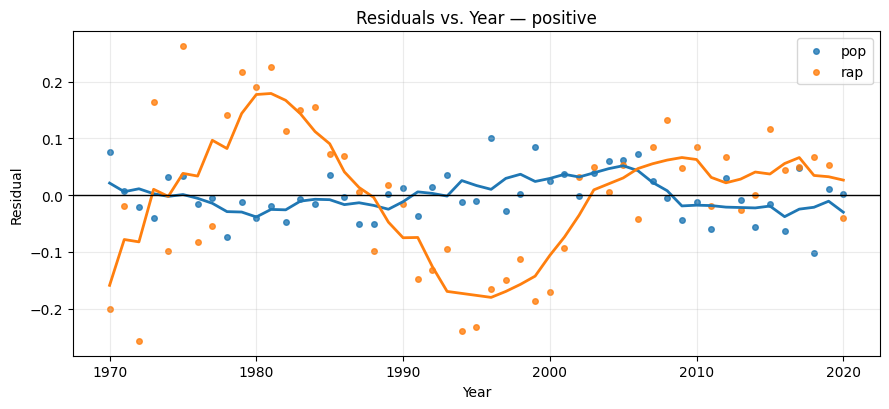

Saved: /Users/dariya/Desktop/thesis/outputs/fig_resid_positive.png


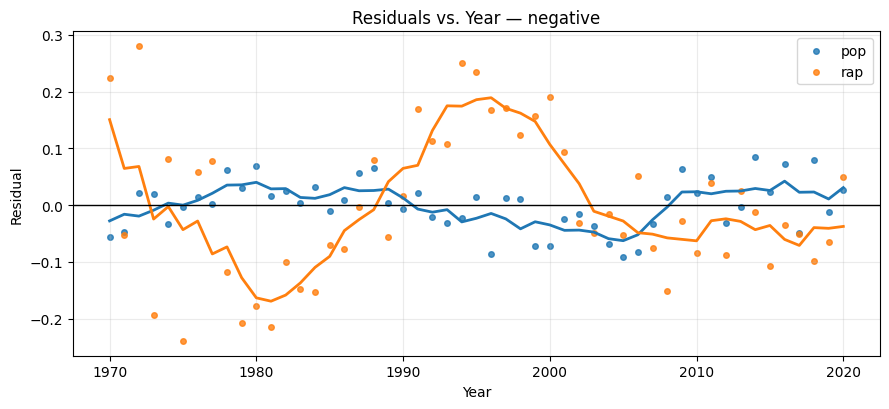

Saved: /Users/dariya/Desktop/thesis/outputs/fig_resid_negative.png


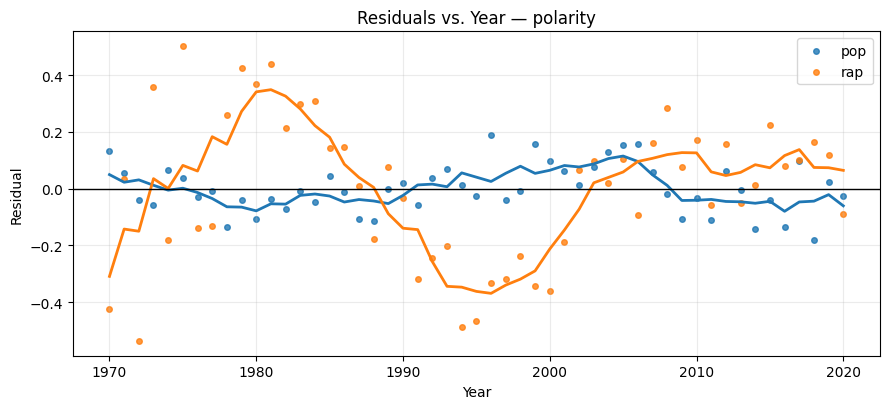

Saved: /Users/dariya/Desktop/thesis/outputs/fig_resid_polarity.png


In [ ]:
def residuals_df(df, ycol):
    df2, _, _, beta = fitted_lines(df, ycol)
    r = df2[[ "genre","year", ycol, "yhat"]].copy()
    r["resid"] = r[ycol] - r["yhat"]
    return r

def plot_residuals(df, ycol, fname):
    r = residuals_df(df, ycol)
    plt.figure(figsize=(9,4.2))
    for g, gdf in r.groupby("genre"):
        gdf = gdf.sort_values("year")
        plt.scatter(gdf["year"], gdf["resid"], s=16, label=g, alpha=.8)
        # 5-yr smoothing of residuals to spot structure
        sm = gdf["resid"].rolling(5, center=True, min_periods=1).mean()
        plt.plot(gdf["year"], sm, linewidth=2)
    plt.axhline(0, color="k", linewidth=1)
    plt.title(f"Residuals vs. Year — {ycol}")
    plt.xlabel("Year"); plt.ylabel("Residual")
    plt.grid(alpha=.25); plt.legend()
    out = BASE / fname
    plt.tight_layout(); plt.savefig(out, dpi=200); plt.show()
    print("Saved:", out)

plot_residuals(d_plot, "positive", "fig_resid_positive.png")
plot_residuals(d_plot, "negative", "fig_resid_negative.png")
plot_residuals(d_plot, "polarity", "fig_resid_polarity.png")


E1. Positive residuals

Rap residuals: slightly positive around late 1970s/early 1980s, negative around early–mid 1990s, then modestly positive again in the 2010s.

Pop residuals: small fluctuations around zero.
Read it: suggests some curvature by sub-period for rap, but no pattern that overturns the downward trend.

E2. Negative residuals

Rap residuals become positive around early–mid 1990s (actual negativity higher than the linear fit), then moderate.

Pop residuals: low-amplitude wiggles.
Read it: again, mild curvature; linear model captures the long-run move.

E3. Polarity residuals

Mirrors the above: rap polarity residuals high ~late 1970s/early 1980s, low ~mid-1990s, drifting toward zero later.
Read it: no strong heteroskedasticity/funneling; nonlinearity exists but doesn’t reverse the core divergence.

Caption (generic for the 3 plots): “Residuals versus year show mild decade-level curvature (especially for rap) but no patterns that negate the significant interaction; linear trends summarize the long-run shift.”

Across 1970–2020, pop lyrics remain predominantly positive and drift down slightly, whereas rap shows a marked decline in positive and rise in negative sentiment from the 1980s onward. Neutral and ambiguous categories are negligible. Five-year smoothed series and OLS with a genre–time interaction confirm significant divergence: rap’s positive share decreases by ~5.2 pp per decade relative to pop (t=−3.99**), its negative share increases by ~5.0 pp per decade (t=3.79***), and its polarity (positive−negative) drops by ~10.2 pp per decade (t=−3.91***). Fitted lines match the observed series, while residual plots indicate mild decade-level curvature (especially for rap) but no patterns that overturn the long-run divergence.*

In [ ]:
import numpy as np, pandas as pd

rng = np.random.default_rng(42)

# Use your 'd' from earlier (centered decades, with columns: genre, year, positive, negative)
# If not in memory, rebuild 'd' from 'wide':
# d = wide.copy(); d["year_dec"]=(d["year"]-1970)/10.0; d["is_rap"]=(d["genre"]=="rap").astype(int)

def ols_beta(X, y):
    return np.linalg.lstsq(X, y, rcond=None)[0]

def interaction_coef(df, ycol):
    X = np.c_[np.ones(len(df)), df["year_dec"].values, df["is_rap"].values,
              (df["year_dec"]*df["is_rap"]).values]
    y = df[ycol].values
    b = ols_beta(X, y)
    return b[3]  # Year(dec)×is_rap

def block_boot_ci(df, ycol, B=2000, block_len=5):
    df = df.sort_values(["genre","year"]).reset_index(drop=True)
    years = np.sort(df["year"].unique())
    # we resample block indices of years; preserve both genres per year
    n = len(years)
    blocks = [years[i:i+block_len] for i in range(0, n - block_len + 1)]
    coefs = []
    for _ in range(B):
        sample_years = []
        while len(sample_years) < n:
            block = blocks[rng.integers(0, len(blocks))]
            sample_years.extend(block.tolist())
        sample_years = np.array(sample_years[:n])
        sdf = df[df["year"].isin(sample_years)].copy()
        # keep one of each year (since we may duplicate); use first occurrence
        sdf = (sdf.sort_values(["year","genre"])
                 .drop_duplicates(subset=["year","genre"], keep="first"))
        coefs.append(interaction_coef(sdf, ycol))
    coefs = np.array(coefs)
    return np.percentile(coefs, [2.5, 50, 97.5])

# Build polarity
d_bs = d.copy()
d_bs["polarity"] = d_bs["positive"] - d_bs["negative"]

for target in ["positive","negative","polarity"]:
    lo, med, hi = block_boot_ci(d_bs, target, B=2000, block_len=5)
    print(f"{target}: Year(dec)×is_rap bootstrap 95% CI = [{lo:.4f}, {hi:.4f}]  (median {med:.4f})")


positive: Year(dec)×is_rap bootstrap 95% CI = [-0.1246, -0.0213]  (median -0.0619)
negative: Year(dec)×is_rap bootstrap 95% CI = [0.0160, 0.1183]  (median 0.0591)
polarity: Year(dec)×is_rap bootstrap 95% CI = [-0.2429, -0.0393]  (median -0.1224)


In [ ]:
import numpy as np, pandas as pd

def fit_piecewise(gdf, ycol, min_year=1975, max_year=2015):
    gdf = gdf.dropna(subset=[ycol]).sort_values("year")
    years = gdf["year"].values
    x = (years - 1970)/10.0  # decades
    y = gdf[ycol].values

    best = None
    for br in range(min_year, max_year+1):
        t = (years >= br).astype(float)
        X = np.c_[np.ones(len(x)), x, t, x*t]  # intercept, slope pre, level jump, slope change
        beta, *_ = np.linalg.lstsq(X, y, rcond=None)
        resid = y - X@beta
        sse = float(resid@resid)
        if (best is None) or (sse < best[0]):
            best = (sse, br, beta)
    sse, br, beta = best
    # slopes per decade: pre = beta1 ; post = beta1 + beta3
    slope_pre, slope_change = beta[1], beta[3]
    slope_post = slope_pre + slope_change
    return {"break_year": br,
            "slope_pre_pp_dec": slope_pre*100,
            "slope_post_pp_dec": slope_post*100,
            "slope_change_pp_dec": slope_change*100}

# Apply to POLARITY per genre
d_pw = d.copy()
d_pw["polarity"] = d_pw["positive"] - d_pw["negative"]
for g, gdf in d_pw.groupby("genre"):
    res = fit_piecewise(gdf, "polarity")
    print(g, res)


pop {'break_year': 2008, 'slope_pre_pp_dec': np.float64(0.5153736732684039), 'slope_post_pp_dec': np.float64(-1.7032967032967048), 'slope_change_pp_dec': np.float64(-2.218670376565109)}
rap {'break_year': 1987, 'slope_pre_pp_dec': np.float64(18.96076923330228), 'slope_post_pp_dec': np.float64(-0.8479755538579159), 'slope_change_pp_dec': np.float64(-19.808744787160197)}


In [ ]:
import sys, numpy, scipy, gensim
print(sys.executable)
print("numpy:", numpy.__version__, "scipy:", scipy.__version__, "gensim:", gensim.__version__)


/opt/anaconda3/envs/thesis311/bin/python
numpy: 1.24.4 scipy: 1.10.1 gensim: 4.3.2


In [ ]:
from scipy import linalg as LA
import numpy as np
print("triu present:", hasattr(LA, "triu"))
print(LA.triu(np.ones((2,2))).shape)


triu present: True
(2, 2)


In [ ]:
# Cell 1: imports & config
from pathlib import Path
import re, json, math, random
import numpy as np
import pandas as pd

# text / topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases, LdaModel
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# plotting
import matplotlib.pyplot as plt

# spaCy (for lemmatization + POS)
import spacy
from spacy.cli import download as spacy_download



RANDOM_STATE = 100
np.random.seed(RANDOM_STATE); random.seed(RANDOM_STATE)


lyrics_top100_en_rap_pop_1970_2020_CLEANEST.parquet

In [ ]:
# Step 2 — LOAD CLEANEST (batch-safe, no pandas/metadata pitfalls)
from pathlib import Path
import pandas as pd, numpy as np, ast
import pyarrow.dataset as ds

BASE = Path.home() / "Desktop" / "thesis"
OUT  = BASE / "outputs"

SRC = next((p for p in [
    OUT / "lyrics_top100_en_rap_pop_1970_2020_CLEANEST.parquet",
    OUT / "lyrics_top100_en_rap_pop_1970_2020_clean.parquet",
    OUT / "lyrics_top100_by_year_genre_CLEAN.parquet",
] if p.exists()), None)
if SRC is None:
    raise FileNotFoundError("No CLEAN/CLEANEST parquet found in ~/Desktop/thesis/outputs/")
print("Reading (batch-safe):", SRC.name)

# 1) Inspect dataset schema and choose only the columns we need
dset   = ds.dataset(str(SRC), format="parquet")
names  = set(dset.schema.names)
pick   = lambda *opts: next((o for o in opts if o in names), None)

col_year  = pick("year","release_year","chart_year")
col_genre = pick("genre","primary_genre","main_genre")
col_tok   = pick("tokens_clean","tokens","tokens_final")
col_text  = pick("lyrics_cleanest","lyrics_clean","lyrics_text","lyrics")
col_id    = pick("song_id","track_id","id","uid")

if col_year is None or col_genre is None or (col_tok is None and col_text is None):
    raise ValueError(f"Missing required columns in {SRC.name}")

cols = [c for c in [col_year, col_genre, col_tok, col_text, col_id] if c]

# 2) Stream batches and materialize to plain Python lists (no pandas/Arrow metadata)
acc = {c: [] for c in cols}
for batch in dset.to_batches(columns=cols):  # batch is a pyarrow.RecordBatch
    for c in cols:
        i = batch.schema.get_field_index(c)
        acc[c].extend(batch.column(i).to_pylist())

raw = pd.DataFrame(acc)

# 3) Normalize names to what downstream cells expect
if col_id is None:
    raw["song_id"] = np.arange(len(raw))
else:
    raw = raw.rename(columns={col_id: "song_id"})

raw = raw.rename(columns={
    col_year:  "year",
    col_genre: "genre",
    **({col_tok: "tokens_clean"} if col_tok else {}),
    **({col_text:"lyrics_cleanest"} if col_text else {}),
})

# 4) Ensure tokens_clean is list[str]; if absent/serialized, derive from lyrics_cleanest
def coerce_tokens(x):
    if isinstance(x, list):
        return [t for t in x if isinstance(t, str) and t]
    if isinstance(x, str):
        s = x.strip()
        if s.startswith("[") and s.endswith("]"):
            try:
                y = ast.literal_eval(s)
                if isinstance(y, list):
                    return [t for t in y if isinstance(t, str) and t]
            except Exception:
                pass
        return [t for t in s.split() if t]
    return []

if "tokens_clean" in raw.columns:
    raw["tokens_clean"] = raw["tokens_clean"].map(coerce_tokens)
else:
    raw["tokens_clean"] = raw["lyrics_cleanest"].astype(str).map(lambda s: [t for t in s.split() if t])

# 5) Filter to your study window and genres; keep only the needed columns
raw["year"]  = pd.to_numeric(raw["year"], errors="coerce")
raw["genre"] = raw["genre"].astype(str).str.lower()
df = (raw.dropna(subset=["year"])
         .loc[lambda d: (d["year"].between(1970, 2020)) & (d["genre"].isin(["pop","rap"])),
              ["song_id","year","genre","tokens_clean","lyrics_cleanest"]]
         .reset_index(drop=True))

print(df.shape)
print(df.genre.value_counts(dropna=False).to_string())
display(df.head(3))


Reading (batch-safe): lyrics_top100_en_rap_pop_1970_2020_CLEANEST.parquet
(9417, 5)
genre
pop    5100
rap    4317


,song_id,year,genre,tokens_clean,lyrics_cleanest
0,0,1970,pop,"[bird, suddenly, appear, every, time, near, li...",bird suddenly appear every time near like long...
1,1,1970,pop,"[bless, day, pinnacle, life, husband, join, wi...",bless day pinnacle life husband join wife hear...
2,2,1970,pop,"[bobby, bobby, bobby, baby, bobby, bubi, robby...",bobby bobby bobby baby bobby bubi robby robert...


In [ ]:
# === Normalization — Cell A: imports, downloads, regex helpers ===
from pathlib import Path
import re, unicodedata
import numpy as np, pandas as pd

import nltk
# Small, one-time downloads (quiet if already present)
for pkg in ["punkt","stopwords","wordnet","omw-1.4",
            "averaged_perceptron_tagger","averaged_perceptron_tagger_eng"]:
    try:
        nltk.data.find(pkg if "/" in pkg else f"corpora/{pkg}")
    except LookupError:
        try:
            nltk.download(pkg, quiet=True)
        except Exception:
            pass

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk import word_tokenize, pos_tag

# Project paths
BASE = Path.home() / "Desktop" / "thesis"
OUT  = BASE / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

# --- negation-aware stopwords (keep negators) ---
NEGATORS = {"no","not","nor","never","n't","dont","doesnt","didnt","cant","couldnt","wont",
            "wouldnt","isnt","arent","aint","havent","hasnt","hadnt","shouldnt","mustnt",
            "wasnt","werent"}
STOP = set(stopwords.words("english"))
STOP = STOP - NEGATORS

# Pronouns + fillers (domain noise)
PRONOUNS = {
    "i","me","my","mine","myself","you","your","yours","yourself","yourselves","u","ur",
    "he","him","his","himself","she","her","hers","herself","it","its","itself","we","us",
    "our","ours","ourselves","they","them","their","theirs","themselves","ya","yall","yo",
}
FILLERS = {
    "oh","ooh","ah","uh","hmm","mmm","hey","ayy","yah","la","na","nanana","woah","whoa",
    "woo","skrrt","bruh","yeah","yea","ok","okay","huh","ha","haha","doo","da"
}
STOP |= PRONOUNS | FILLERS

# --- regexes ---
RE_BRACKETS = re.compile(r"\[[^\]]*\]")                 # [Chorus], [Verse 1], etc.
RE_PARENS   = re.compile(r"\([^\)]*\)")                 # (chorus), (repeat), …
RE_EMAIL    = re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}")
RE_URL      = re.compile(r"https?://\S+|www\.\S+")
RE_HTML     = re.compile(r"<[^>]+>")
RE_MISCWS   = re.compile(r"\s+")
RE_TOKEN_RB = re.compile(r"[a-z]+'?[a-z]+|[a-z]+", re.I) # rule-based tokenization (keeps don't→don't)

# contraction pass focused on *negation* (we keep the negators as tokens)
CONTRACTIONS = {
    "don't":"dont","doesn't":"doesnt","didn't":"didnt","can't":"cant","couldn't":"couldnt",
    "won't":"wont","wouldn't":"wouldnt","isn't":"isnt","aren't":"arent","ain't":"aint",
    "haven't":"havent","hasn't":"hasnt","hadn't":"hadnt","shouldn't":"shouldnt",
    "mustn't":"mustnt","wasn't":"wasnt","weren't":"werent",
}

def normalize_text_base(txt: str) -> str:
    if not isinstance(txt, str):
        return ""
    # normalize unicode and lower
    t = unicodedata.normalize("NFKC", txt).lower()
    # strip html & bracketed/parenthetical stage directions
    t = RE_HTML.sub(" ", t)
    t = RE_BRACKETS.sub(" ", t)
    t = RE_PARENS.sub(" ", t)
    # remove urls, collect emails separately later
    t = RE_URL.sub(" ", t)
    # normalize common negation contractions
    for k,v in CONTRACTIONS.items():
        t = t.replace(k, v)
    # collapse whitespace
    t = RE_MISCWS.sub(" ", t).strip()
    return t

def regex_extract_emails(txt: str):
    return RE_EMAIL.findall(txt or "")


In [ ]:
# === Normalization — Cell B: tokenization, stopwords, lemma, stems, POS ===

LEM = WordNetLemmatizer()
PST = PorterStemmer()
SNB = SnowballStemmer("english")

def tokens_rule_based(txt: str):
    return RE_TOKEN_RB.findall(txt or "")

def tokens_whitespace(txt: str):
    return [w for w in (txt or "").split() if w.isalpha()]

def remove_stop(xs):
    return [w for w in xs if w not in STOP]

def lemmatize(xs):
    # simple 2-pass (verb then noun) lemmatization
    return [LEM.lemmatize(LEM.lemmatize(w, "v"), "n") for w in xs]

def stem_porter(xs):
    return [PST.stem(w) for w in xs]

def stem_snowball(xs):
    return [SNB.stem(w) for w in xs]

# POS tagging (uses NLTK tagger; returns coarse Penn tags)
def pos_tags_for(xs):
    # NLTK expects untokenized strings or tokens; we pass tokens
    try:
        return pos_tag(xs, tagset=None)
    except LookupError:
        nltk.download("averaged_perceptron_tagger", quiet=True)
        nltk.download("averaged_perceptron_tagger_eng", quiet=True)
        return pos_tag(xs, tagset=None)

# ---- choose the base text column: lyrics_cleanest > lyrics_clean > lyrics ----
text_col = "lyrics_cleanest" if "lyrics_cleanest" in df.columns else (
           "lyrics_clean"    if "lyrics_clean"    in df.columns else "lyrics")

base = df[text_col].astype(str).map(normalize_text_base)

# A little metadata: any emails present (rare for lyrics, but for the RE step)
df["norm_emails"] = base.map(regex_extract_emails).map(lambda xs: xs if xs else np.nan)

# Tokenization variants
df["norm_tokens_ws"]   = base.map(tokens_whitespace)
df["norm_tokens_rule"] = base.map(tokens_rule_based)

# Stopword removal (keep negators)
df["norm_tokens_nostop"] = df["norm_tokens_rule"].map(remove_stop)

# Lemmatization
df["norm_tokens_lemma"] = df["norm_tokens_nostop"].map(lemmatize)

# Stemming (two common stemmers)
df["norm_tokens_porter"]   = df["norm_tokens_nostop"].map(stem_porter)
df["norm_tokens_snowball"] = df["norm_tokens_nostop"].map(stem_snowball)

# POS tags (on the cleaned, no-stop tokens; keeps (word, tag) tuples)
# If you prefer tags only: [t for _,t in pos_tags_for(xs)]
df["norm_pos_tags"] = df["norm_tokens_nostop"].map(pos_tags_for)

print("Normalization layers added. Preview:")
display(df[["genre","year",
            "norm_tokens_rule","norm_tokens_nostop",
            "norm_tokens_lemma","norm_tokens_porter",
            "norm_pos_tags"]].head(3))


Normalization layers added. Preview:


,genre,year,norm_tokens_rule,norm_tokens_nostop,norm_tokens_lemma,norm_tokens_porter,norm_pos_tags
0,pop,1970,"[bird, suddenly, appear, every, time, near, li...","[bird, suddenly, appear, every, time, near, li...","[bird, suddenly, appear, every, time, near, li...","[bird, suddenli, appear, everi, time, near, li...","[(bird, NN), (suddenly, RB), (appear, VB), (ev..."
1,pop,1970,"[bless, day, pinnacle, life, husband, join, wi...","[bless, day, pinnacle, life, husband, join, wi...","[bless, day, pinnacle, life, husband, join, wi...","[bless, day, pinnacl, life, husband, join, wif...","[(bless, JJ), (day, NN), (pinnacle, VB), (life..."
2,pop,1970,"[bobby, bobby, bobby, baby, bobby, bubi, robby...","[bobby, bobby, bobby, baby, bobby, bubi, robby...","[bobby, bobby, bobby, baby, bobby, bubi, robby...","[bobbi, bobbi, bobbi, babi, bobbi, bubi, robbi...","[(bobby, NN), (bobby, NN), (bobby, NN), (baby,..."


In [ ]:
# --- make everything Arrow-friendly and write with an explicit schema ---

import pyarrow as pa, pyarrow.parquet as pq

# ensure scalar text columns are plain Python str under the hood
g["genre"]  = g["genre"].astype(str)
g[text_col] = g[text_col].astype(str)

schema = pa.schema([
    ("song_id", pa.int64()),
    ("year", pa.int64()),
    ("genre", pa.string()),
    (text_col, pa.string()),
    ("norm_tokens_rule",      pa.list_(pa.string())),
    ("norm_tokens_nostop",    pa.list_(pa.string())),
    ("norm_tokens_lemma",     pa.list_(pa.string())),
    ("norm_tokens_porter",    pa.list_(pa.string())),
    ("norm_tokens_snowball",  pa.list_(pa.string())),
    ("norm_pos_tags",         pa.list_(pa.string())),
    ("norm_emails",           pa.list_(pa.string())),
])

cols = [ "song_id","year","genre",text_col,
         "norm_tokens_rule","norm_tokens_nostop","norm_tokens_lemma",
         "norm_tokens_porter","norm_tokens_snowball","norm_pos_tags","norm_emails" ]

# build Arrow arrays explicitly (avoid pandas extension dtypes)
arrays = []
for fld in schema:
    name = fld.name
    # pandas Series -> plain Python list
    pylist = g[name].tolist()
    # list -> Arrow Array of the correct field type
    arrays.append(pa.array(pylist, type=fld.type))

tbl = pa.Table.from_arrays(arrays, schema=schema)

out_parq = OUT / "lyrics_normalized_layers.parquet"
pq.write_table(tbl, out_parq)
print("Saved (explicit schema):", out_parq)


Saved (explicit schema): /Users/dariya/Desktop/thesis/outputs/lyrics_normalized_layers.parquet


"The" is tagged as determiner (DT)
"quick" is tagged as adjective (JJ)
"brown" is tagged as adjective (JJ)
"fox" is tagged as noun (NN)
"jumps" is tagged as verb (VBZ)
"over" is tagged as preposition (IN)
"the" is tagged as determiner (DT)
"lazy" is tagged as adjective (JJ)
"dog" is tagged as noun (NN)

In [ ]:
# === G1 (fixed): batch-safe loader for Lyrics_normalized_layers.parquet ===
from pathlib import Path
import pandas as pd
import pyarrow.dataset as ds

BASE = Path.home() / "Desktop" / "thesis"
OUT  = BASE / "outputs"
SRC  = OUT / "Lyrics_normalized_layers.parquet"  # exact name from your save step

dset = ds.dataset(str(SRC), format="parquet")
names = set(dset.schema.names)

# pick the best token column available
tok_col = next((c for c in ["norm_tokens_lemma","norm_tokens_nostop",
                            "norm_tokens_rule","tokens_clean"] if c in names), None)
assert tok_col, f"No token column found; columns are: {sorted(names)}"

# optional meta
opt = [c for c in ["artist","song_name"] if c in names]

cols = ["song_id","year","genre", tok_col, *opt]
acc = {c: [] for c in cols}

for batch in dset.to_batches(columns=cols):
    sch = batch.schema
    for c in cols:
        acc[c].extend(batch.column(sch.get_field_index(c)).to_pylist())

df = pd.DataFrame(acc)

# constrain to study window
df["year"]  = pd.to_numeric(df["year"], errors="coerce")
df["genre"] = df["genre"].astype(str).str.lower()
df = df.loc[df["genre"].isin(["pop","rap"]) & df["year"].between(1970, 2020)].reset_index(drop=True)

# build joined text used by TF-IDF/transformers
df["doc_text"] = df[tok_col].map(lambda xs: " ".join(xs if isinstance(xs, list) else []))

print("Rows:", len(df), "| token column:", tok_col)
display(df[["song_id","genre","year",tok_col]].head(3))


Rows: 9417 | token column: norm_tokens_lemma


,song_id,genre,year,norm_tokens_lemma
0,0,pop,1970,"[bird, suddenly, appear, every, time, near, li..."
1,1,pop,1970,"[bless, day, pinnacle, life, husband, join, wi..."
2,2,pop,1970,"[bobby, bobby, bobby, baby, bobby, bubi, robby..."


In [ ]:
assert "doc_text" in df.columns, "Нужен df['doc_text'] (склеенные токены)."
tok_col = next((c for c in ["norm_tokens_lemma","norm_tokens_nostop","norm_tokens_rule","tokens_clean"] if c in df.columns), None)
assert tok_col, f"Не найден столбец с токенами. Есть: {list(df.columns)}"
print("OK:", len(df), "docs | tokens:", tok_col)

OK: 9417 docs | tokens: norm_tokens_lemma


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=25,        # при малом корпусе можно 15
    max_df=0.6,
    token_pattern=r"(?u)\b\w+\b",
    sublinear_tf=True,
    lowercase=False,  # мы уже нормализовали
    analyzer=str.split # подаём "doc_text" как строки из токенов
)
X = tfidf.fit_transform(df["doc_text"])
V = np.array(tfidf.get_feature_names_out())
X.shape, len(V)

/opt/anaconda3/envs/thesis311/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(
/opt/anaconda3/envs/thesis311/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:547: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


((9417, 4553), 4553)

Вариант 1

In [ ]:
# %% NMF topics — English-only vocab + clean topic words (no manual stoplists)
from pathlib import Path
import numpy as np, pandas as pd, re, json, math
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from joblib import dump
import pyarrow.dataset as ds

# ---------- helpers ----------
def arr1(x):
    # всегда получаем 1D numpy array (вместо .A1, совместимо с ndarray/CSR)
    return np.asarray(x).ravel()

# авто-установка и импорт wordfreq для англо-фильтрации словаря
try:
    from wordfreq import zipf_frequency
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordfreq", "-q"])
    from wordfreq import zipf_frequency

def englishish_token(token: str) -> bool:
    """
    Оставляем токены с достаточной частотой в английском по wordfreq.
    Порог: жёстче для коротких, мягче для длинных.
    """
    if len(token) <= 2:
        return False
    z = zipf_frequency(token, "en")  # log10(freq per billion)
    if len(token) <= 3:
        return z >= 3.5   # убирает inna, ting, mi/di/fi/dem и т.п.
    elif len(token) <= 6:
        return z >= 3.2
    else:
        return z >= 3.0

def englishish_term(term: str) -> bool:
    if " " in term:
        a, b = term.split(" ", 1)
        return englishish_token(a) and englishish_token(b)
    return englishish_token(term)

BASE = Path.home() / "Desktop" / "thesis"
OUT  = BASE / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

NORM_PARQ = OUT / "lyrics_normalized_layers.parquet"

N_TOPICS        = 7
TOP_WORDS_PER_T = 40
TOP_SONGS_PER_T = 10
MIN_DF_ABS      = 10
MAX_DF_FRAC     = 0.7
MAX_FEATURES    = 50000
NGRAMS          = (1, 1)   

try:
    assert 'df' in globals() and 'doc_text' in df.columns
except:
    dset = ds.dataset(str(NORM_PARQ), format="parquet")
    names = set(dset.schema.names)
    tok_col = next((c for c in ["norm_tokens_lemma","norm_tokens_nostop","norm_tokens_rule","tokens_clean"] if c in names), None)
    assert tok_col, f"Нет токен-колонки в {NORM_PARQ.name}: есть {sorted(names)}"
    meta_cols = [c for c in ["song_id","artist","song_name","genre","year"] if c in names]
    cols = [tok_col, *meta_cols]
    acc = {c: [] for c in cols}
    for b in dset.to_batches(columns=cols):
        sch = b.schema
        for c in cols:
            acc[c].extend(b.column(sch.get_field_index(c)).to_pylist())
    df = pd.DataFrame(acc)
    # doc_text как строка из токенов
    df["doc_text"] = df[tok_col].map(lambda xs: " ".join(xs if isinstance(xs, list) else []))

if "genre" in df.columns:
    df["genre"] = df["genre"].astype(str).str.lower()
    df = df[df["genre"].isin(["pop","rap"])]
if "year" in df.columns:
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df = df[df["year"].between(1970, 2020, inclusive="both")]

# мета-колонки/заглушки
if "song_id" not in df.columns:
    df["song_id"] = np.arange(len(df), dtype=np.int64)
if "song_name" not in df.columns:
    df["song_name"] = df["doc_text"].str.split().map(lambda xs: " ".join(xs[:6]) if isinstance(xs, list) else str(xs)[:40])
if "artist" not in df.columns:
    df["artist"] = "(unknown)"

# мягкий фильтр коротких текстов
df = df[df["doc_text"].str.len().fillna(0) > 20].reset_index(drop=True)
print("Docs:", len(df), "| avg len (words):", int(df["doc_text"].str.split().map(len).mean()))

# ---------- 2) TF-IDF с англо-фильтрацией словаря ----------
stop_auto = set(ENGLISH_STOP_WORDS) - {"no","not","nor","never"}  # сохраняем негаторы

# PASS 1: черновой словарь на корпусе
vec_probe = TfidfVectorizer(
    stop_words=list(stop_auto),
    token_pattern=r"(?u)\b[a-z]{2,}\b",
    ngram_range=NGRAMS,
    min_df=MIN_DF_ABS,
    max_df=MAX_DF_FRAC,
    max_features=MAX_FEATURES,
    lowercase=False,
    sublinear_tf=True
)
X_probe = vec_probe.fit_transform(df["doc_text"])
vocab_probe = np.array(vec_probe.get_feature_names_out())

# фильтр: оставляем только «английские» термины (уни- и биграммы)
vocab_final = [t for t in vocab_probe if englishish_term(t)]

# PASS 2: финальный TF-IDF по отфильтрованному словарю
vec = TfidfVectorizer(
    stop_words=list(stop_auto),
    token_pattern=r"(?u)\b[a-z]{2,}\b",
    ngram_range=NGRAMS,
    min_df=MIN_DF_ABS,
    max_df=MAX_DF_FRAC,
    max_features=None,          # берём весь отфильтрованный словарь
    lowercase=False,
    sublinear_tf=True,
    vocabulary=vocab_final
)
X = vec.fit_transform(df["doc_text"])
vocab = np.array(vec.get_feature_names_out())
idf = vec.idf_
print("TF-IDF matrix (english-only):", X.shape)

# ---------- 3) NMF (как у тебя) ----------
nmf = NMF(
    n_components=N_TOPICS,
    init="nndsvd",
    random_state=42,
    max_iter=600,
    alpha_W=0.0, alpha_H=0.0, l1_ratio=0.0,
    beta_loss="frobenius", solver="cd"
)
W = nmf.fit_transform(X)     # doc-topic
H = nmf.components_          # topic-term
print(f"Reconstruction error: {nmf.reconstruction_err_:.4f}")

# ---------- 4) TOP WORDS: softer filtering (topic-local salience) ----------
from sklearn.preprocessing import normalize

# нормируем W по строкам
W_row_norm = normalize(W, norm="l1", axis=1)

# вспомогательные величины
dfreq_global = arr1((X > 0).sum(axis=0))
H_sum = H.sum(axis=0, keepdims=True) + 1e-12
topic_specificity = H / H_sum
vocab = np.array(vec.get_feature_names_out())
idf = vec.idf_

# SOFT-параметры (мягче прежних):
SHORT_MAX_LEN      = 4      # раньше ≤5 — делаем мягче: короткими считаем ≤4
LOCAL_DF_THRESH    = 0.60   # прячем короткие только если они в ≥60% локальных доков (было 0.50)
SPEC_FLOOR         = 0.04   # ниже порог специфичности (было 0.06)
IDF_FLOOR          = 1.40   # ниже порог редкости (было 1.6)
LENGTH_PENALTY     = 0.65   # мягче штраф коротким (было 0.50)
ELIG_RULE_OR       = True   # для коротких: допускаем по ИЛИ (spec ИЛИ idf), раньше было И

lens = np.fromiter((len(t) for t in vocab), dtype=int)
short_mask_global = lens <= SHORT_MAX_LEN



def topic_top_terms(k, topn=30, top_docs=300):
    order_docs = np.argsort(W_row_norm[:,k])[::-1]
    sel_docs = order_docs[:min(top_docs, len(order_docs))]
    weights = W_row_norm[sel_docs, k]

    X_loc = X[sel_docs, :]
    sal   = arr1(X_loc.T @ weights)                           # topic-local salience
    loc_df = arr1((X_loc > 0).sum(axis=0)) / max(1, X_loc.shape[0])

    score = sal * idf
    spec_k = topic_specificity[k]
    short_mask = short_mask_global

    # eligibility: длинные всегда ок; короткие — по ИЛИ (мягко) или И (жёстко)
    if ELIG_RULE_OR:
        eligible_mask = (lens >= 4) | ((idf >= IDF_FLOOR) | (spec_k >= SPEC_FLOOR))
    else:
        eligible_mask = (lens >= 4) | ((idf >= IDF_FLOOR) & (spec_k >= SPEC_FLOOR))

    # мягкий штраф коротким среди eligible
    score[short_mask & eligible_mask] *= LENGTH_PENALTY

    # hide: короткие сверхчасты локально и не удовлетворяют ни idf, ни spec
    hide_short = short_mask & (loc_df >= LOCAL_DF_THRESH) & (~eligible_mask)
    score[hide_short] = -1.0

    # не-eligible совсем не показываем
    score[~eligible_mask] = -1.0

    order = np.argsort(score)[::-1]
    top_idx = [j for j in order if score[j] > 0][:topn]
    return top_idx

def format_topic_words(k, topn=TOP_WORDS_PER_T):
    idx = topic_top_terms(k, topn=topn)
    return [(vocab[j], H[k, j]) for j in idx]

def auto_label_for_topic(k, topn=TOP_WORDS_PER_T):
    idx = topic_top_terms(k, topn=topn)
    words = [vocab[j] for j in idx]
    # в лейбл допускаем чуть короче: >=5 (раньше >=6)
    bigrams = [w for w in words if " " in w][:2]
    unigrams = [w for w in words if " " not in w and len(w) >= 5][:3]
    cand = bigrams + unigrams
    label = " / ".join(cand[:3]) if cand else "Topic"
    return label.title()

topics_words = [format_topic_words(k, TOP_WORDS_PER_T) for k in range(N_TOPICS)]
labels = [auto_label_for_topic(k, TOP_WORDS_PER_T) for k in range(N_TOPICS)]


# ---------- 5) Репрезентативные песни на тему ----------
top_songs_txt, top_songs_idx = [], []
for k in range(N_TOPICS):
    order = np.argsort(W_row_norm[:,k])[::-1]
    idx_k  = [i for i in order[:TOP_SONGS_PER_T] if W_row_norm[i,k] > 0]
    top_songs_idx.append(idx_k)
    rows = []
    for i in idx_k:
        art = str(df.loc[i, "artist"])
        name = str(df.loc[i, "song_name"])
        prob = W_row_norm[i,k]
        rows.append(f"{art} — {name} (p={prob:.3f})")
    top_songs_txt.append("; ".join(rows) if rows else "(нет песен с высокой вероятностью)")

# ---------- 6) Итоговая таблица ----------
def fmt_words(ws, m=TOP_WORDS_PER_T):
    return "; ".join([f"{w} ({wt:.3f})" for w,wt in ws[:m]])

res = pd.DataFrame({
    "topic_id":   range(N_TOPICS),
    "auto_label": labels,
    "top_words":  [fmt_words(ws) for ws in topics_words],
})
print(res)
try:
    display(res)
except:
    pass




# ---------- 7) Сохранение артефактов ----------
res.to_csv(OUT / f"nmf_topics_k{N_TOPICS}.csv", index=False)
dump(nmf, OUT / f"nmf_k{N_TOPICS}.joblib")
dump(vec, OUT / "tfidf_vectorizer.joblib")
np.save(OUT / f"W_doc_topic_k{N_TOPICS}.npy", W_row_norm)
np.save(OUT / f"H_topic_terms_k{N_TOPICS}.npy", H)

meta_cols = [c for c in ["song_id","artist","song_name","genre","year"] if c in df.columns]
(df[meta_cols + ["doc_text"]].head(2) if meta_cols else df.head(2)).to_csv(OUT / "nmf_meta_sample.csv", index=False)

print("Saved:", OUT / f"nmf_topics_k{N_TOPICS}.csv")


Docs: 9417 | avg len (words): 240
TF-IDF matrix (english-only): (9417, 6208)
Reconstruction error: 92.6733
   topic_id                auto_label  \
0         0     Think / Sorry / Thing   
1         1     Bitch / Nigga / Pussy   
2         2     Funky / Party / Disco   
3         3     Dream / Light / Night   
4         4   Tonight / Wanna / Right   
5         5   Heart / Apart / Forever   
6         6  Praise / Jesus / Worship   

                                           top_words  
0  think (0.850); sorry (0.247); thing (0.645); w...  
1  bitch (0.882); nigga (1.172); pussy (0.299); f...  
2  funky (0.351); rock (0.826); party (0.454); di...  
3  dream (0.625); sun (0.515); light (0.548); sky...  
4  baby (1.803); tonight (0.435); wanna (0.679); ...  
5  heart (1.256); apart (0.322); love (1.951); fo...  
6  praise (0.504); jesus (0.566); lord (1.156); w...  


,topic_id,auto_label,top_words
0,0,Think / Sorry / Thing,think (0.850); sorry (0.247); thing (0.645); w...
1,1,Bitch / Nigga / Pussy,bitch (0.882); nigga (1.172); pussy (0.299); f...
2,2,Funky / Party / Disco,funky (0.351); rock (0.826); party (0.454); di...
3,3,Dream / Light / Night,dream (0.625); sun (0.515); light (0.548); sky...
4,4,Tonight / Wanna / Right,baby (1.803); tonight (0.435); wanna (0.679); ...
5,5,Heart / Apart / Forever,heart (1.256); apart (0.322); love (1.951); fo...
6,6,Praise / Jesus / Worship,praise (0.504); jesus (0.566); lord (1.156); w...


Saved: /Users/dariya/Desktop/thesis/outputs/nmf_topics_k7.csv


In [ ]:
from sklearn.preprocessing import normalize
W_l1 = normalize(W, norm="l1", axis=1)

meta_cols = [c for c in ["song_id","artist","song_name","genre","year"] if c in df.columns]
topic_cols = [f"topic_{k}" for k in range(W_l1.shape[1])]
out = pd.concat([
    df[meta_cols].reset_index(drop=True),
    pd.DataFrame(W_l1, columns=topic_cols)
], axis=1)
out["top_topic"] = out[topic_cols].values.argmax(1)
out["top_score"] = out[topic_cols].max(1)
if 'labels' in globals(): out["top_topic_label"] = out["top_topic"].map(dict(enumerate(labels)))
out.to_csv(OUT/"nmf_doc_topics.csv", index=False)
print("→ saved", OUT/"nmf_doc_topics.csv", out.shape)


→ saved /Users/dariya/Desktop/thesis/outputs/nmf_doc_topics.csv (9417, 15)


In [ ]:
if "year" in out.columns:
    by_year = out.groupby(out["year"].astype(int))[topic_cols].mean()
    by_year.to_csv(OUT/"topic_share_by_year.csv")
if "genre" in out.columns:
    by_genre = out.groupby("genre")[topic_cols].mean().sort_index()
    by_genre.to_csv(OUT/"topic_share_by_genre.csv")
print("→ saved by_year/by_genre")


→ saved by_year/by_genre


In [ ]:
def top_songs_for_topic(k, n=15):
    idx = np.argsort(W_l1[:,k])[::-1][:n]
    cols = [c for c in ["artist","song_name","year","genre"] if c in df.columns]
    tab = df.loc[idx, cols].copy()
    tab["p"] = W_l1[idx, k]
    return tab
for k in range(N_TOPICS):
    top_songs_for_topic(k).to_csv(OUT/f"topic{k}_top_songs.csv", index=False)
print("→ saved topic_k top songs")


→ saved topic_k top songs


In [ ]:
from itertools import combinations
X_bin = (X>0).astype(int)
def umass_coherence(k, topn=20):
    idx = np.argsort(H[k])[::-1][:topn]
    score, cnt = 0.0, 0
    for i,j in combinations(idx, 2):
        Dij = (X_bin[:,i].multiply(X_bin[:,j])).sum()
        Dj  = X_bin[:,j].sum()
        score += np.log((Dij + 1) / (Dj + 1e-12))
        cnt += 1
    return score / max(1,cnt)
for k in range(N_TOPICS):
    print(f"Topic {k}: UMass={umass_coherence(k):.3f}")


Topic 0: UMass=-0.664
Topic 1: UMass=-0.889
Topic 2: UMass=-1.356
Topic 3: UMass=-1.466
Topic 4: UMass=-0.850
Topic 5: UMass=-1.380
Topic 6: UMass=-2.227


In [ ]:
Ks = [6,7,8,9,10]
errs = []
for K in Ks:
    nmf_k = NMF(n_components=K, init="nndsvd", random_state=42, max_iter=800, beta_loss="frobenius", solver="cd")
    nmf_k.fit(X)
    errs.append(nmf_k.reconstruction_err_)
list(zip(Ks, errs))


[(6, np.float64(92.80827038886959)),
 (7, np.float64(92.67325452645463)),
 (8, np.float64(92.56577012653838)),
 (9, np.float64(92.46544829959755)),
 (10, np.float64(92.36384896936075))]

In [ ]:
# Вставь один раз вверху блока с графиками
import matplotlib.pyplot as plt
from pathlib import Path

OUT_P = OUT / "plots"
OUT_P.mkdir(parents=True, exist_ok=True)

def save_fig(path: Path, dpi=200):
    fig = plt.gcf()
    fig.savefig(path, bbox_inches="tight", dpi=dpi)
    plt.close(fig)
    print("saved:", path)


In [ ]:
# %% Assign each song its topics + save CSV
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize

# 1) нормируем распределение тем по документам
W_l1 = normalize(W, norm="l1", axis=1)

# 2) таблица с весами тем
df_topics = pd.DataFrame(W_l1, columns=[f"topic_{k}" for k in range(W_l1.shape[1])])
df_topics["top_topic"] = df_topics.values.argmax(axis=1)
df_topics["top_score"] = df_topics.max(axis=1)

# 3) аккуратно подцепляем доступные мета-колонки
meta_cols_order = ["song_id", "artist", "song_name", "genre", "year"]
present_meta = [c for c in meta_cols_order if c in df.columns]
df_meta = df[present_meta].copy() if present_meta else pd.DataFrame(index=df.index)

# 4) объединяем и сохраняем
out = pd.concat([df_meta.reset_index(drop=True), df_topics.reset_index(drop=True)], axis=1)
out_path = OUT / "nmf_doc_topics.csv"
out.to_csv(out_path, index=False)
print(f"→ saved {out_path} | shape={out.shape}")


→ saved /Users/dariya/Desktop/thesis/outputs/nmf_doc_topics.csv | shape=(9417, 14)


→ saved topics tables
→ saved topic_share_by_year.csv
→ saved topic_share_by_genre.csv


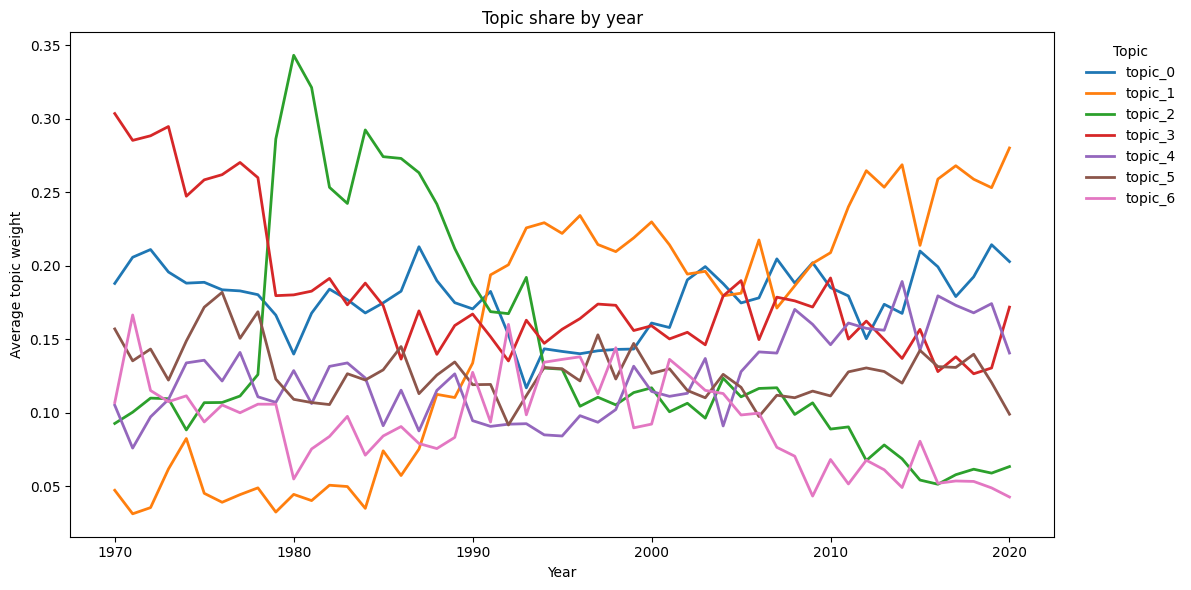

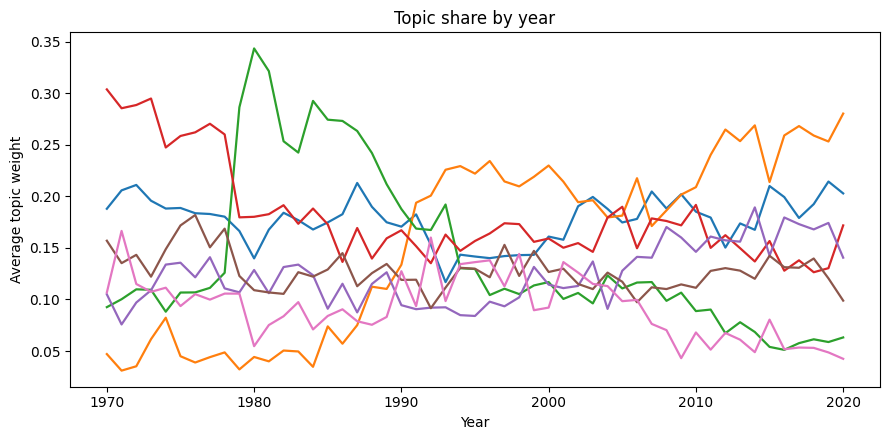

saved: /Users/dariya/Desktop/thesis/outputs/plots/topic_share_by_year.png


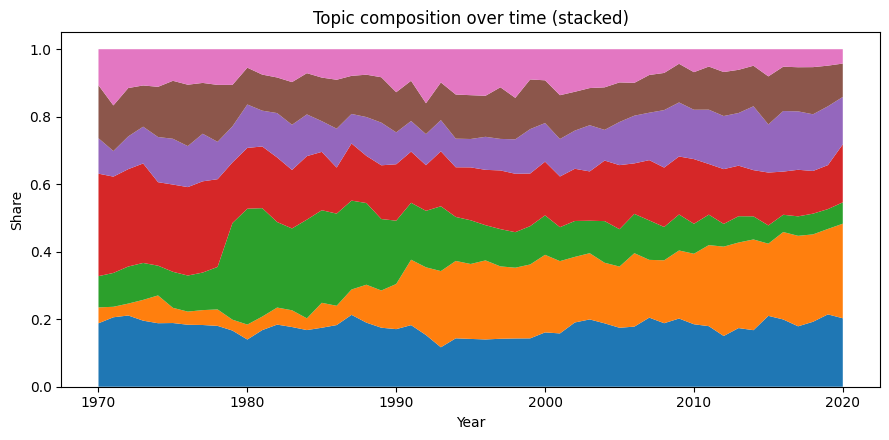

saved: /Users/dariya/Desktop/thesis/outputs/plots/topic_share_by_year_stacked.png


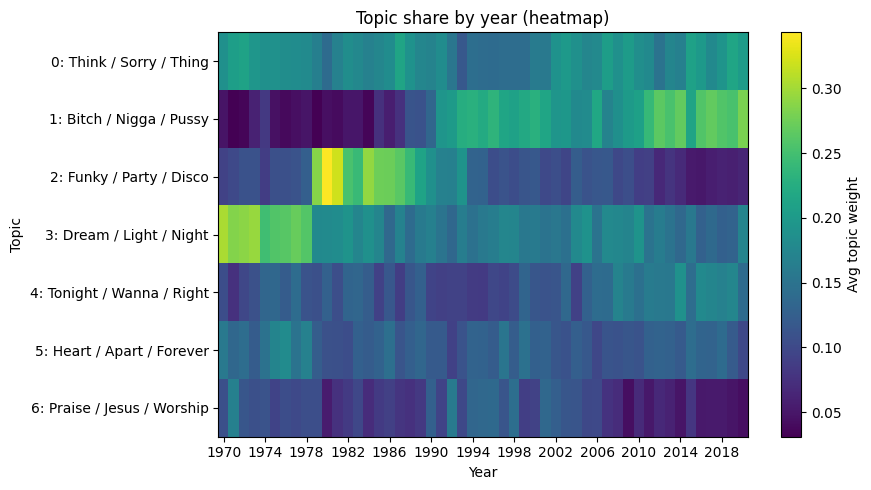

saved: /Users/dariya/Desktop/thesis/outputs/plots/topic_by_year_heatmap.png


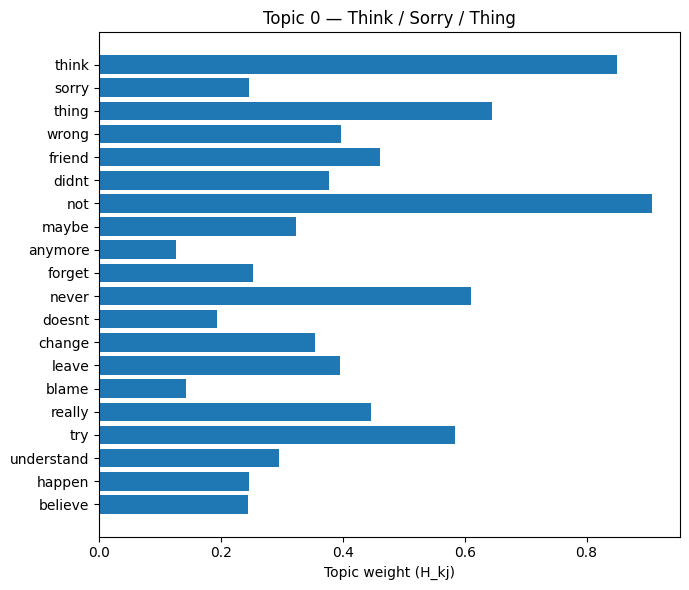

saved: /Users/dariya/Desktop/thesis/outputs/plots/topic0_top_words.png
Done.


In [ ]:
# %% Export tidy artifacts + plots (no songs)
import pandas as pd, numpy as np, os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

OUT_P = OUT / "plots"
OUT_P.mkdir(parents=True, exist_ok=True)

def save_fig(path: Path, dpi=200):
    fig = plt.gcf()
    fig.savefig(path, bbox_inches="tight", dpi=dpi)
    plt.close(fig)
    print("saved:", path)

# 1) Таблица тем (обычная и "clean" без обсцены)
topic_cols = [f"topic_{k}" for k in range(N_TOPICS)] if 'N_TOPICS' in globals() else [f"topic_{k}" for k in range(W.shape[1])]
W_l1 = normalize(W, norm="l1", axis=1)

# если уже есть res/topics_words/labels из твоего пайплайна — используем; иначе соберём базовую табличку
try:
    res_basic = res.copy()
except:
    def fmt_words(ws, m=30): return "; ".join([f"{w} ({wt:.3f})" for w,wt in ws[:m]])
    res_basic = pd.DataFrame({
        "topic_id": range(W.shape[1]),
        "auto_label": [labels[k] if 'labels' in globals() else f"Topic {k}" for k in range(W.shape[1])],
        "top_words": ["; ".join([])]*W.shape[1]  # если нет topics_words — оставим пустым
    })

# clean-версия без обсцены (только для отчёта)
BAD = {"f"}
try:
    res_clean = res_basic.copy()
    if 'topics_words' in globals():
        def fmt_words_clean(ws, m=30):
            clean = [(w,wt) for (w,wt) in ws if w.lower() not in BAD]
            return "; ".join([f"{w} ({wt:.3f})" for w,wt in clean[:m]]) or "(filtered)"
        res_clean["top_words"] = [fmt_words_clean(ws) for ws in topics_words]
except Exception:
    res_clean = res_basic.copy()

res_basic.to_csv(OUT / f"nmf_topics_k{W.shape[1]}.csv", index=False)
res_clean.to_csv(OUT / f"nmf_topics_k{W.shape[1]}_clean.csv", index=False)
print("→ saved topics tables")

# 2) Доли тем по годам/жанрам
df_topics = pd.DataFrame(W_l1, columns=[f"topic_{k}" for k in range(W_l1.shape[1])])
by_year, by_genre = None, None

if "year" in df.columns:
    by_year = (
        pd.concat([df["year"].reset_index(drop=True), df_topics], axis=1)
          .dropna(subset=["year"])
          .assign(year=lambda x: x["year"].astype(int))
          .groupby("year")[df_topics.columns.tolist()].mean()
          .sort_index()
    )
    by_year.to_csv(OUT / "topic_share_by_year.csv")
    print("→ saved topic_share_by_year.csv")

if "genre" in df.columns:
    by_genre = (
        pd.concat([df["genre"].astype(str).str.lower().reset_index(drop=True), df_topics], axis=1)
          .groupby("genre")[df_topics.columns.tolist()].mean()
          .sort_index()
    )
    by_genre.to_csv(OUT / "topic_share_by_genre.csv")
    print("→ saved topic_share_by_genre.csv")

fig, ax = plt.subplots(figsize=(12,6))
for col in by_year.columns:                     # columns = topics
    ax.plot(by_year.index, by_year[col], label=col, linewidth=2)

ax.set_title("Topic share by year")
ax.set_xlabel("Year")
ax.set_ylabel("Average topic weight")

# place legend outside so it doesn’t cover lines
ax.legend(title="Topic", ncol=1, loc="upper left",
          bbox_to_anchor=(1.02, 1.0), frameon=False)
plt.tight_layout()
plt.show()

# 3) Графики (если есть 'year')
if by_year is not None and len(by_year) > 0:
    # линии
    plt.figure(figsize=(9,4.5))
    for c in df_topics.columns:
        plt.plot(by_year.index, by_year[c], linewidth=1.6)
    plt.title("Topic share by year"); plt.xlabel("Year"); plt.ylabel("Average topic weight")
    plt.tight_layout(); plt.show(); save_fig(OUT_P / "topic_share_by_year.png")

    # стек-области
    plt.figure(figsize=(9,4.5))
    plt.stackplot(by_year.index, by_year.T.values, labels=df_topics.columns)
    plt.title("Topic composition over time (stacked)")
    plt.xlabel("Year"); plt.ylabel("Share")
    plt.tight_layout(); plt.show(); save_fig(OUT_P / "topic_share_by_year_stacked.png")

    # тепловая карта
    M = by_year.values.T
    plt.figure(figsize=(9,5))
    plt.imshow(M, aspect="auto", interpolation="nearest")
    plt.colorbar(label="Avg topic weight")
    ytick = [f"{i}: {labels[i]}" if 'labels' in globals() else f"{i}" for i in range(W.shape[1])]
    plt.yticks(range(len(ytick)), ytick)
    step = max(1, len(by_year)//12)
    plt.xticks(range(0, len(by_year.index), step), by_year.index[::step])
    plt.title("Topic share by year (heatmap)")
    plt.xlabel("Year"); plt.ylabel("Topic")
    plt.tight_layout(); plt.show(); save_fig(OUT_P / "topic_by_year_heatmap.png")
else:
    print("No 'year' column → пропустили временные графики.")

# 4) Бар-чарт топ-слов для одной темы (если есть topics_words)
if 'topics_words' in globals():
    K = 0  # поменяй нужную тему
    top = topics_words[K][:20]
    words = [w for w,_ in top][::-1]
    vals  = [v for _,v in top][::-1]
    plt.figure(figsize=(7,6))
    plt.barh(range(len(words)), vals)
    plt.yticks(range(len(words)), words)
    ttl = f"Topic {K}" + (f" — {labels[K]}" if 'labels' in globals() else "")
    plt.title(ttl); plt.xlabel("Topic weight (H_kj)")
    plt.tight_layout(); plt.show(); save_fig(OUT_P / f"topic{K}_top_words.png")
else:
    print("No 'topics_words' → пропустили barh.")

print("Done.")


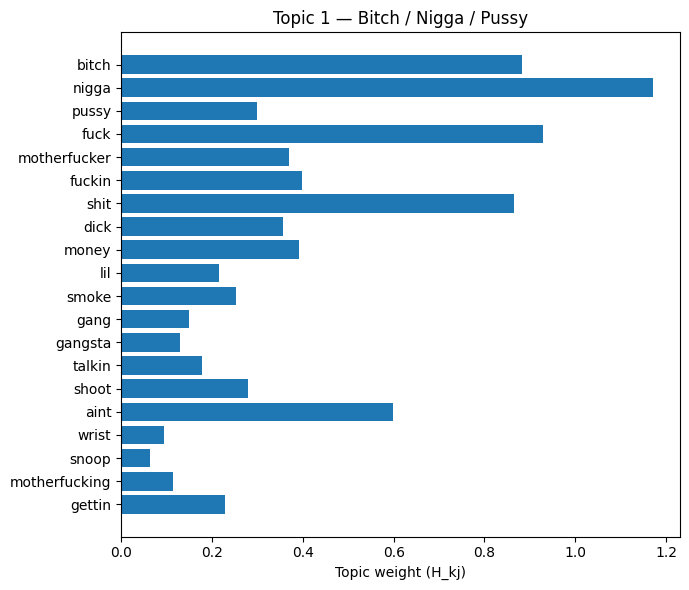

saved: /Users/dariya/Desktop/thesis/outputs/plots/topic1_top_words.png


In [ ]:
if 'topics_words' in globals():
    K = 1  # поменяй нужную тему
    top = topics_words[K][:20]
    words = [w for w,_ in top][::-1]
    vals  = [v for _,v in top][::-1]
    plt.figure(figsize=(7,6))
    plt.barh(range(len(words)), vals)
    plt.yticks(range(len(words)), words)
    ttl = f"Topic {K}" + (f" — {labels[K]}" if 'labels' in globals() else "")
    plt.title(ttl); plt.xlabel("Topic weight (H_kj)")
    plt.tight_layout(); plt.show(); save_fig(OUT_P / f"topic{K}_top_words.png")
else:
    print("No 'topics_words' → пропустили barh.")

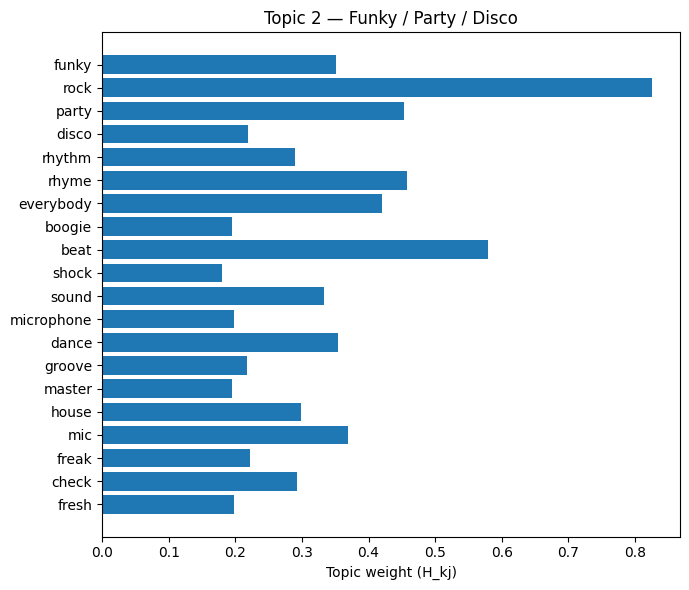

saved: /Users/dariya/Desktop/thesis/outputs/plots/topic2_top_words.png


In [ ]:
if 'topics_words' in globals():
    K = 2  # поменяй нужную тему
    top = topics_words[K][:20]
    words = [w for w,_ in top][::-1]
    vals  = [v for _,v in top][::-1]
    plt.figure(figsize=(7,6))
    plt.barh(range(len(words)), vals)
    plt.yticks(range(len(words)), words)
    ttl = f"Topic {K}" + (f" — {labels[K]}" if 'labels' in globals() else "")
    plt.title(ttl); plt.xlabel("Topic weight (H_kj)")
    plt.tight_layout(); plt.show(); save_fig(OUT_P / f"topic{K}_top_words.png")
else:
    print("No 'topics_words' → пропустили barh.")

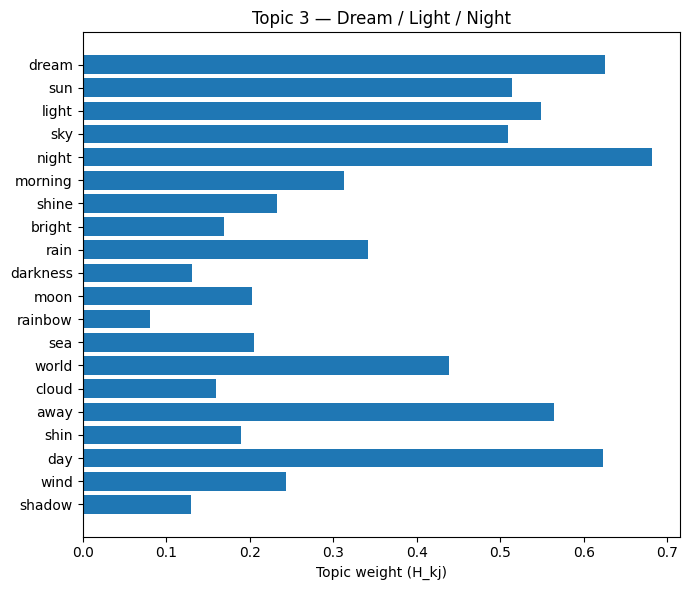

saved: /Users/dariya/Desktop/thesis/outputs/plots/topic3_top_words.png


In [ ]:
if 'topics_words' in globals():
    K = 3  # поменяй нужную тему
    top = topics_words[K][:20]
    words = [w for w,_ in top][::-1]
    vals  = [v for _,v in top][::-1]
    plt.figure(figsize=(7,6))
    plt.barh(range(len(words)), vals)
    plt.yticks(range(len(words)), words)
    ttl = f"Topic {K}" + (f" — {labels[K]}" if 'labels' in globals() else "")
    plt.title(ttl); plt.xlabel("Topic weight (H_kj)")
    plt.tight_layout(); plt.show(); save_fig(OUT_P / f"topic{K}_top_words.png")
else:
    print("No 'topics_words' → пропустили barh.")

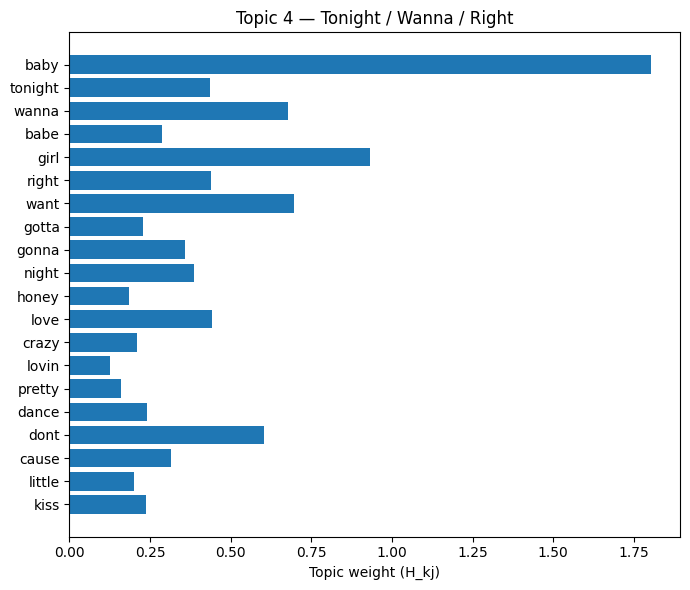

saved: /Users/dariya/Desktop/thesis/outputs/plots/topic4_top_words.png


In [ ]:
if 'topics_words' in globals():
    K = 4  # поменяй нужную тему
    top = topics_words[K][:20]
    words = [w for w,_ in top][::-1]
    vals  = [v for _,v in top][::-1]
    plt.figure(figsize=(7,6))
    plt.barh(range(len(words)), vals)
    plt.yticks(range(len(words)), words)
    ttl = f"Topic {K}" + (f" — {labels[K]}" if 'labels' in globals() else "")
    plt.title(ttl); plt.xlabel("Topic weight (H_kj)")
    plt.tight_layout(); plt.show(); save_fig(OUT_P / f"topic{K}_top_words.png")
else:
    print("No 'topics_words' → пропустили barh.")

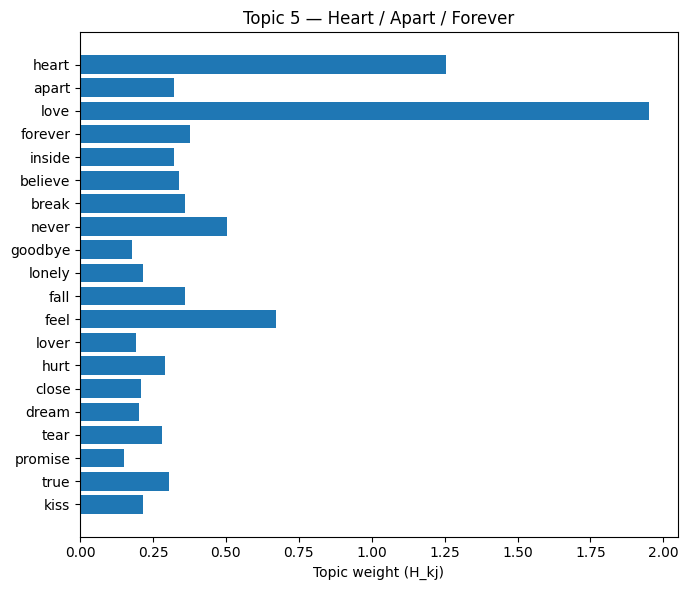

saved: /Users/dariya/Desktop/thesis/outputs/plots/topic5_top_words.png


In [ ]:
if 'topics_words' in globals():
    K = 5  # поменяй нужную тему
    top = topics_words[K][:20]
    words = [w for w,_ in top][::-1]
    vals  = [v for _,v in top][::-1]
    plt.figure(figsize=(7,6))
    plt.barh(range(len(words)), vals)
    plt.yticks(range(len(words)), words)
    ttl = f"Topic {K}" + (f" — {labels[K]}" if 'labels' in globals() else "")
    plt.title(ttl); plt.xlabel("Topic weight (H_kj)")
    plt.tight_layout(); plt.show(); save_fig(OUT_P / f"topic{K}_top_words.png")
else:
    print("No 'topics_words' → пропустили barh.")

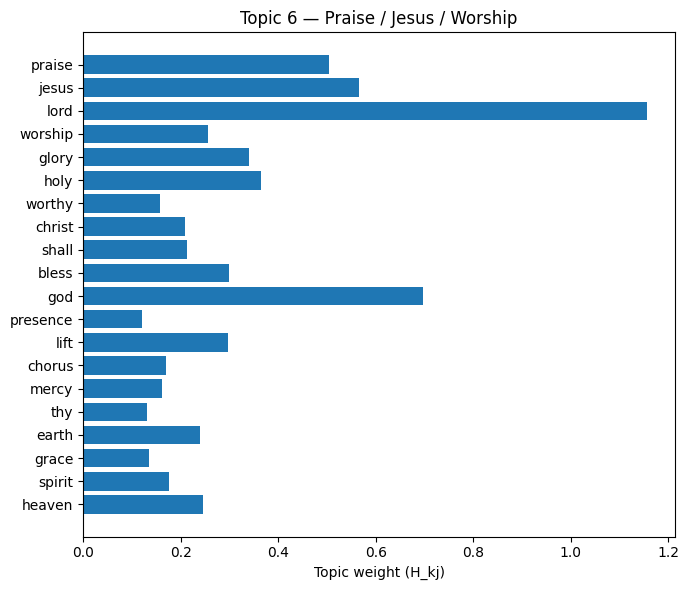

saved: /Users/dariya/Desktop/thesis/outputs/plots/topic6_top_words.png


In [ ]:
if 'topics_words' in globals():
    K = 6  # поменяй нужную тему
    top = topics_words[K][:20]
    words = [w for w,_ in top][::-1]
    vals  = [v for _,v in top][::-1]
    plt.figure(figsize=(7,6))
    plt.barh(range(len(words)), vals)
    plt.yticks(range(len(words)), words)
    ttl = f"Topic {K}" + (f" — {labels[K]}" if 'labels' in globals() else "")
    plt.title(ttl); plt.xlabel("Topic weight (H_kj)")
    plt.tight_layout(); plt.show(); save_fig(OUT_P / f"topic{K}_top_words.png")
else:
    print("No 'topics_words' → пропустили barh.")

In [ ]:
# %% FULL table: topic × sentiment — r, r², b, R², p  (neutral и ambiguous раздельно)
import numpy as np, pandas as pd, re
from scipy.stats import pearsonr, t as t_dist
from pathlib import Path

BASE = Path.home()/ "Desktop"/ "thesis"
OUT  = BASE / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

# ---- 0) Ожидаем, что df уже есть (из шага merge тем с твоим VADER-сентиментом)
assert "df" in globals(), "Нужен df (документы со столбцами topic_* и 'sentiment')."
topic_cols = [c for c in df.columns if re.match(r"^topic_\d+$", str(c))]
assert topic_cols, "Не нашёл topic_* столбцы."

# ---- 1) поможем с красивыми лейблами тем (если файл есть)
label_map = {}
for f in [(OUT/f"nmf_topics_k{len(topic_cols)}.csv"),
          (OUT/"nmf_topics_k7.csv"), (OUT/"nmf_topics_k8.csv"),
          (OUT/"nmf_topics_k9.csv"), (OUT/"nmf_topics_k10.csv")]:
    if f.exists():
        t = pd.read_csv(f)
        if {"topic_id","auto_label"} <= set(t.columns):
            label_map = {f"topic_{int(i)}": str(a) for i,a in zip(t["topic_id"], t["auto_label"])}
            break
labels = {c: label_map.get(c, c) for c in topic_cols}

# ---- 2) математика: r/p_r и OLS b/R²/p_b
SENTS = ["positive","negative","neutral","ambiguous"]

def ols_b_r2_p(y, x):
    """OLS: y ~ 1 + x (x — бинарный 0/1) → b1, R², p, n."""
    m = np.isfinite(y) & np.isfinite(x)
    y, x = y[m].astype(float), x[m].astype(float)
    n = int(len(y))
    if n < 3 or np.isclose(x.std(), 0) or np.isclose(y.std(), 0):
        return np.nan, np.nan, np.nan, n
    X = np.c_[np.ones(n), x]
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)   # [b0, b1]
    yhat = X @ beta
    resid = y - yhat
    sse = float(resid @ resid)
    sst = float(((y - y.mean())**2).sum())
    r2  = 1 - sse/sst
    k   = 2
    sigma2 = sse / (n - k)
    cov = sigma2 * np.linalg.inv(X.T @ X)
    se_b1 = float(np.sqrt(cov[1,1]))
    t = float(beta[1] / se_b1)
    p = float(2 * t_dist.sf(abs(t), n - k))
    return float(beta[1]), float(r2), p, n

def safe_pearsonr(y, x):
    m = np.isfinite(y) & np.isfinite(x)
    y, x = y[m], x[m]
    if len(y) < 3 or np.isclose(y.std(), 0) or np.isclose(x.std(), 0):
        return np.nan, np.nan
    r, p = pearsonr(y, x)
    return float(r), float(p)

rows = []
for c in topic_cols:
    y = pd.to_numeric(df[c], errors="coerce").values
    for s in SENTS:
        x = (df["sentiment"] == s).astype(float).values
        r, p_r = safe_pearsonr(y, x)
        b, R2, p_b, n = ols_b_r2_p(y, x)
        rows.append({
            "topic": c, "label": labels[c], "sentiment": s,
            "r": r, "r2": (np.nan if pd.isna(r) else r*r),
            "b": b, "R2": R2, "p_b": p_b, "p_r": p_r, "n": n
        })

long = pd.DataFrame(rows)

# ---- 3) wide «полная» таблица (одна строка = тема; по каждому классу 4 столбца)
def colblock(df, sent, what):
    return df[df["sentiment"]==sent].set_index("label")[what].rename(f"{sent} {what}")

wide = None
for s in SENTS:
    block = pd.concat([
        colblock(long, s, "r"),
        colblock(long, s, "r2"),
        colblock(long, s, "b"),
        colblock(long, s, "R2"),
        colblock(long, s, "p_b"),   # p из OLS (для «звёздочек» и отчёта)
    ], axis=1)
    wide = block if wide is None else wide.join(block, how="outer")

# порядок столбцов покомпактнее
ordered_cols = []
for s in SENTS:
    ordered_cols += [f"{s} r", f"{s} r2", f"{s} b", f"{s} R2", f"{s} p_b"]
wide = wide[ordered_cols].sort_index()

# ---- 4) сохранение
long.to_csv(OUT/"topic_sentiment_FULL_long.csv", index=False)
wide.to_csv(OUT/"topic_sentiment_FULL_wide.csv", index=True)

# ---- 5) красивая печать (округлим, добавим звёздочки по p_b)
def stars(p):
    return "***" if pd.notna(p) and p < 1e-3 else ("**" if pd.notna(p) and p < 1e-2 else ("*" if pd.notna(p) and p < 5e-2 else ""))

pretty = wide.copy()
for s in SENTS:
    # r
    pretty[f"{s} r"]  = pretty[f"{s} r"].map(lambda v: "" if pd.isna(v) else f"{v:+.3f}")
    pretty[f"{s} r2"] = pretty[f"{s} r2"].map(lambda v: "" if pd.isna(v) else f"{v:.3f}"[1:] if 0 <= v < 1 else f"{v:.3f}")
    # b + звёздочки по p_b
    pretty[f"{s} b"]  = [
        "" if pd.isna(b) else f"{b:+.3f}{stars(p)}"
        for b, p in zip(wide[f"{s} b"], wide[f"{s} p_b"])
    ]
    # R² в стиле .500
    pretty[f"{s} R2"] = pretty[f"{s} R2"].map(lambda v: "" if pd.isna(v) else f"{v:.3f}"[1:] if 0 <= v < 1 else f"{v:.3f}")
    # p отдельно (OLS)
    pretty[f"{s} p_b"] = pretty[f"{s} p_b"].map(lambda v: "" if pd.isna(v) else f"{v:.3g}")

pretty.to_csv(OUT/"topic_sentiment_FULL_pretty.csv")

print("Saved:\n - topic_sentiment_FULL_long.csv\n - topic_sentiment_FULL_wide.csv\n - topic_sentiment_FULL_pretty.csv")
try:
    display(pretty.style.set_properties(**{"text-align":"center"})
                    .set_table_styles([{"selector":"th","props":[("text-align","center"),("background","#00001A")]}]))
except Exception:
    print(pretty.head(10).to_string())


AssertionError: Нужен df (документы со столбцами topic_* и 'sentiment').

In [ ]:
# %% Compact table: only b and R² per sentiment
from pathlib import Path
import pandas as pd

BASE = Path.home()/ "Desktop"/ "thesis"
OUT  = BASE / "outputs"

# 1) берём pretty из памяти или с диска
try:
    tbl = pretty.copy()
except NameError:
    tbl = pd.read_csv(OUT/"topic_sentiment_FULL_pretty.csv")

# 2) какие колонки оставляем (только OLS: b и R² по каждому классу)
keep = [
    "positive b","positive R2",
    "negative b","negative R2",
    "neutral b","neutral R2",
    "ambiguous b","ambiguous R2",
]

# на всякий — нормализуем заголовки и выкидываем лишнее
cols_have = [c for c in keep if c in tbl.columns]
if "label" not in tbl.columns:
    # иногда «label» мог стать индексом при сохранении/чтении
    tbl = tbl.rename_axis("label").reset_index()

compact = tbl[["label"] + cols_have].copy()

# 3) чуть приятнее подписи колонок
ren = {
    "positive b":"Positive b", "positive R2":"Positive R²",
    "negative b":"Negative b", "negative R2":"Negative R²",
    "neutral b":"Neutral b",   "neutral R2":"Neutral R²",
    "ambiguous b":"Ambiguous b","ambiguous R2":"Ambiguous R²",
}
compact = compact.rename(columns=ren)

# 4) сохранить и показать
out_path = OUT / "topic_sentiment_b_R2_pretty.csv"
compact.to_csv(out_path, index=False)
print("Saved:", out_path.name)

# быстрый приевью (первые строки)
display(compact.head(10))


Saved: topic_sentiment_b_R2_pretty.csv


,label,Positive b,Positive R²,Negative b,Negative R²,Neutral b,Neutral R²,Ambiguous b,Ambiguous R²
0,Bitch / Nigga / Pussy,-0.188***,.185,+0.199***,.202,-0.037,.000,-0.062***,.002
1,Dream / Light / Night,+0.046***,.014,-0.053***,.019,+0.037,.000,+0.056***,.002
2,Funky / Party / Disco,+0.029***,.006,-0.030***,.006,+0.024,.000,-0.008,.000
3,Heart / Apart / Forever,+0.061***,.035,-0.062***,.036,-0.041*,.000,+0.011,.000
4,Praise / Jesus / Worship,+0.026***,.007,-0.026***,.007,+0.032,.000,-0.016,.000
5,Think / Sorry / Thing,-0.013***,.002,+0.012***,.001,-0.013,.000,+0.026*,.001
6,Tonight / Wanna / Right,+0.039***,.015,-0.039***,.015,-0.002,.000,-0.008,.000


In [ ]:
# %% Split Neutral vs Ambiguous + pretty table
from pathlib import Path
import pandas as pd, numpy as np, re, warnings
warnings.filterwarnings("ignore")

BASE = Path.home()/ "Desktop"/ "thesis"
OUT  = BASE / "outputs"

# ---------- 0) восстановим df и topic_cols при необходимости ----------
need_reload = ("df" not in globals()) or ("topic_cols" not in globals())

if need_reload:
    # 0.1 topics
    T = pd.read_csv(OUT/"nmf_doc_topics.csv")
    topic_cols = [c for c in T.columns if re.fullmatch(r"topic_\d+", c)]
    assert topic_cols, "В nmf_doc_topics.csv нет столбцов topic_*."

    # 0.2 корпус + sentiment (как в предыдущем шаге)
    import pyarrow.dataset as ds
    NORM_PARQ = OUT / "lyrics_normalized_layers.parquet"
    dset = ds.dataset(str(NORM_PARQ), format="parquet")
    names = set(dset.schema.names)
    tok_col = next((c for c in ["norm_tokens_lemma","norm_tokens_nostop","norm_tokens_rule","tokens_clean"] if c in names), None)
    assert tok_col, f"Не найден столбец токенов: есть {sorted(names)}"
    meta = [c for c in ["song_id","artist","song_name","genre","year"] if c in names]
    cols = [tok_col, *meta]
    acc = {c: [] for c in cols}
    for b in dset.to_batches(columns=cols):
        sch = b.schema
        for c in cols:
            acc[c].extend(b.column(sch.get_field_index(c)).to_pylist())
    D = pd.DataFrame(acc)
    if "genre" in D.columns:
        D["genre"] = D["genre"].astype(str).str.lower()
        D = D[D["genre"].isin(["pop","rap"])]
    if "year" in D.columns:
        D["year"] = pd.to_numeric(D["year"], errors="coerce")
        D = D[D["year"].between(1970, 2020, inclusive="both")]
    D["doc_text"] = D[tok_col].map(lambda xs: " ".join(xs if isinstance(xs, list) else []))
    D["song_key"] = D["doc_text"].map(lambda s: " ".join((s or "").split()[:6]).lower())
    if "song_name" not in D.columns or D["song_name"].isna().all():
        D["song_name"] = D["song_key"]
    if "artist" not in D.columns:
        D["artist"] = "(unknown)"

    import nltk
    from nltk.sentiment import SentimentIntensityAnalyzer
    try:
        nltk.data.find("sentiment/vader_lexicon.zip")
    except LookupError:
        nltk.download("vader_lexicon", quiet=True)
    sia = SentimentIntensityAnalyzer()
    def vader4(text: str) -> str:
        c = sia.polarity_scores(text or "").get("compound", 0.0)
        if c >= 0.2:   return "positive"
        if c <= -0.2:  return "negative"
        return "neutral" if abs(c) < 0.05 else "ambiguous"
    D["sentiment"] = D["doc_text"].map(vader4)

    # merge (song_id предпочтительно; иначе year+song_key)
    if "song_id" in T.columns and "song_id" in D.columns:
        df = T.merge(D[["song_id","year","genre","artist","song_name","sentiment"]],
                     on="song_id", how="left")
    else:
        if "year" not in T.columns:
            T = T.copy()
            T["year"] = D["year"].values[:len(T)]
        T["song_key"] = T.get("song_name","").astype(str).str.lower()
        df = T.merge(D[["song_key","year","genre","artist","song_name","sentiment"]],
                     on=["song_key","year"], how="left")

print("Doc-level rows:", len(df), "| topics:", len(topic_cols))

# ---------- 1) корреляции с раздельными Neutral и Ambiguous ----------
try:
    from scipy.stats import t as t_dist
    def p_from_r(r, n):
        r2 = r*r
        t = abs(r) * np.sqrt((n-2)/max(1e-12, 1-r2))
        return float(2 * t_dist.sf(t, n-2))
except Exception:
    def p_from_r(r, n):
        r2 = r*r
        t = abs(r) * np.sqrt((n-2)/max(1e-12, 1-r2))
        # нормальное приближение
        return float(2 * (1 - 0.5*(1+np.math.erf(t/np.sqrt(2)))))

def corr_pair(x, y):
    m = np.isfinite(x) & np.isfinite(y)
    n = int(m.sum())
    if n < 3: return np.nan, np.nan, n
    # константы → NaN
    if np.allclose(np.std(x[m]), 0) or np.allclose(np.std(y[m]), 0):
        return np.nan, np.nan, n
    r = float(np.corrcoef(x[m], y[m])[0,1])
    return r, p_from_r(r, n), n

def corr_doc_split(df, topic_cols):
    yP = (df["sentiment"]=="positive").astype(float).values
    yN = (df["sentiment"]=="negative").astype(float).values
    yU = (df["sentiment"]=="neutral").astype(float).values
    yA = (df["sentiment"]=="ambiguous").astype(float).values
    rows=[]
    for c in topic_cols:
        x = pd.to_numeric(df[c], errors="coerce").values
        rP,pP,n = corr_pair(x, yP)
        rN,pN,_ = corr_pair(x, yN)
        rU,pU,_ = corr_pair(x, yU)
        rA,pA,_ = corr_pair(x, yA)
        rows.append({"topic":c,"n":n,
                     "r_pos":rP,"p_pos":pP,
                     "r_neg":rN,"p_neg":pN,
                     "r_neu":rU,"p_neu":pU,
                     "r_amb":rA,"p_amb":pA})
    return pd.DataFrame(rows)

doc_split = corr_doc_split(df, topic_cols)

# ---------- 2) прикрутим лейблы тем ----------
label_map = {}
K_guess = len(topic_cols)
for K in [K_guess, 7,8,9,10]:
    f = OUT / f"nmf_topics_k{K}.csv"
    if f.exists():
        L = pd.read_csv(f)
        if {"topic_id","auto_label"} <= set(L.columns):
            label_map = {f"topic_{int(i)}": str(a) for i,a in zip(L["topic_id"], L["auto_label"])}
        break
doc_split["label"] = doc_split["topic"].map(label_map).fillna(doc_split["topic"])

# ---------- 3) pretty-таблица ----------
def stars(p):
    return "***" if pd.notna(p) and p < 0.001 else ("**" if pd.notna(p) and p < 0.01 else ("*" if pd.notna(p) and p < 0.05 else ""))

def fmt_rp(r, p):
    return "" if pd.isna(r) else f"{r:+.3f}{stars(p)}"

pretty = (doc_split
          .sort_values("label")
          .loc[:, ["label","r_pos","p_pos","r_neg","p_neg","r_neu","p_neu","r_amb","p_amb"]]
          .rename(columns={"r_pos":"Positive r","p_pos":"Positive p",
                           "r_neg":"Negative r","p_neg":"Negative p",
                           "r_neu":"Neutral r","p_neu":"Neutral p",
                           "r_amb":"Ambiguous r","p_amb":"Ambiguous p"}))

# Отдельная версия без p-колонок, со звёздочками прямо в r:
pretty_compact = pretty[["label","Positive r","Negative r","Neutral r","Ambiguous r"]].copy()
for col_r, col_p in [("Positive r","Positive p"),("Negative r","Negative p"),
                     ("Neutral r","Neutral p"),("Ambiguous r","Ambiguous p")]:
    pretty_compact[col_r] = [fmt_rp(r, p) for r,p in zip(pretty[col_r], pretty[col_p])]

# ---------- 4) сохранить и показать ----------
doc_split.to_csv(OUT/"topic_sentiment_doc_corr_SPLIT_raw.csv", index=False)
pretty.to_csv(OUT/"topic_sentiment_doc_corr_SPLIT_with_p.csv", index=False)
pretty_compact.to_csv(OUT/"topic_sentiment_doc_corr_SPLIT_pretty.csv", index=False)

print("Saved:")
print(" - topic_sentiment_doc_corr_SPLIT_raw.csv")
print(" - topic_sentiment_doc_corr_SPLIT_with_p.csv")
print(" - topic_sentiment_doc_corr_SPLIT_pretty.csv")

# Красивый вывод в ноутбуке:
try:
    display(pretty_compact.style.hide(axis="index")
            .set_table_styles([{"selector":"th","props":[("text-align","left")]}])
            .set_properties(**{"text-align":"center"}, subset=pretty_compact.columns[1:])
           )
except Exception:
    print("\nPreview:")
    print(pretty_compact.head(10).to_string(index=False))


Doc-level rows: 9417 | topics: 7
Saved:
 - topic_sentiment_doc_corr_SPLIT_raw.csv
 - topic_sentiment_doc_corr_SPLIT_with_p.csv
 - topic_sentiment_doc_corr_SPLIT_pretty.csv


label,Positive r,Negative r,Neutral r,Ambiguous r
Bitch / Nigga / Pussy,-0.430***,+0.450***,-0.015,-0.041***
Dream / Light / Night,+0.120***,-0.137***,+0.016,+0.042***
Funky / Party / Disco,+0.077***,-0.079***,+0.011,-0.006
Heart / Apart / Forever,+0.188***,-0.189***,-0.021*,+0.010
Praise / Jesus / Worship,+0.083***,-0.082***,+0.017,-0.014
Think / Sorry / Thing,-0.042***,+0.036***,-0.007,+0.024*
Tonight / Wanna / Right,+0.122***,-0.121***,-0.001,-0.007


Самые сильные эффекты

“Bitch / Nigga / Pussy”

Negative b = +0.199* (R² .202) — мощнейшая связь с негативом. +10 п.п. этой темы → +2.0 п.п. к вероятности негативного сентимента.

Positive b = −0.188* (R² .185) — симметрично «выедает» позитив. +10 п.п. темы → −1.9 п.п. к позитиву.

Ambiguous b = −0.062*** (R² .002) — чуть меньше неоднозначности; нейтраль — н/з.

“Heart / Apart / Forever” (любовь/отношения)

Positive b = +0.061 (R² .035), Negative b = −0.062* (R² .036).
+10 п.п. темы → +0.6 п.п. к позитиву и −0.6 п.п. к негативу. Нейтраль чуть убывает (−0.041*, R²≈0).

“Dream / Light / Night” (мечты/томления)

Positive b = +0.046* (R² .014), Negative b = −0.053* (R² .019).
+10 п.п. → +0.46 п.п. к позитиву и −0.53 п.п. к негативу.

Ambiguous b = +0.056* (R² .002) — повышается «амбивалентность».

Средние по силе эффекты

“Tonight / Wanna / Right” (желание/романс)

Positive +0.039* (R² .015), Negative −0.039* (R² .015). Чёткий «позитив против негатива».

“Funky / Party / Disco” (тусовки/танцы)

Positive +0.029* (R² .006), Negative −0.030* (R² .006). Небольшой, но устойчивый «смещатель» к позитиву.

“Praise / Jesus / Worship” (религиозные мотивы)

Positive +0.026* (R² .007), Negative −0.026* (R² .007). Лёгкий крен в позитив.

Слабые/смешанные

“Think / Sorry / Thing” (рефлексия/извинения)

Positive −0.013* (R² .002), Negative +0.012* (R² .001) — мелкие, но значимые сдвиги в «минус позитив / плюс негатив».

Ambiguous +0.026* (R² .001) — больше неоднозначности, что логично по смыслу.

Нейтральный класс

По всем темам нейтральный b маленький и чаще незначим (R²≈0), исключение — лёгкое снижение у «Heart…» (−0.041*, R²≈0), рост у «Dream…» (+0.037, н/з).

Merge ok: 9,417 строк | лет: 1970–2020 | темы: 7


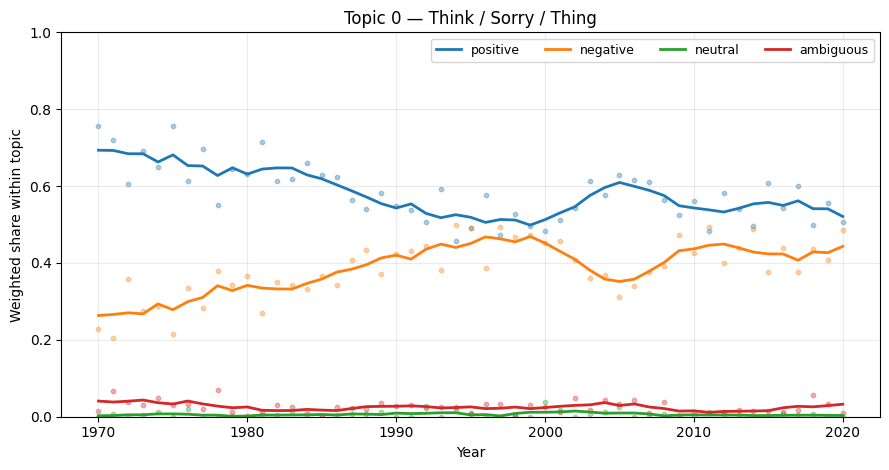

saved: /Users/dariya/Desktop/thesis/outputs/plots_topic_sentiment_trends/topic0_sentiment_trend.png | /Users/dariya/Desktop/thesis/outputs/topic0_sentiment_yearly.csv


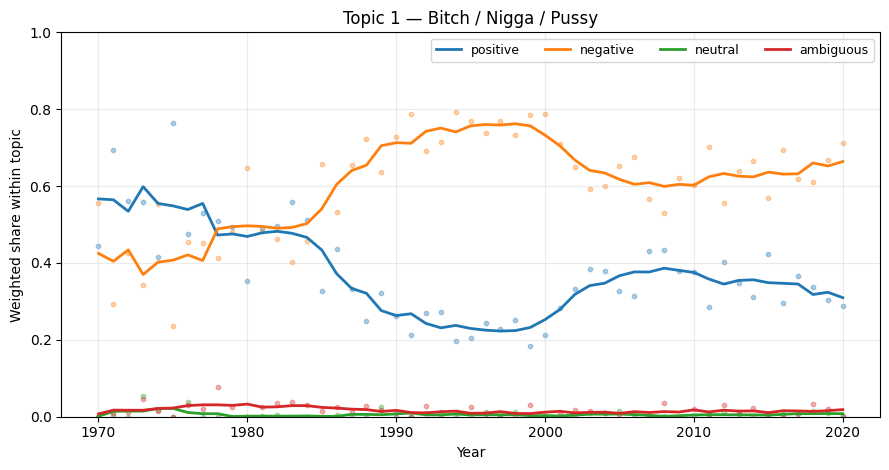

saved: /Users/dariya/Desktop/thesis/outputs/plots_topic_sentiment_trends/topic1_sentiment_trend.png | /Users/dariya/Desktop/thesis/outputs/topic1_sentiment_yearly.csv


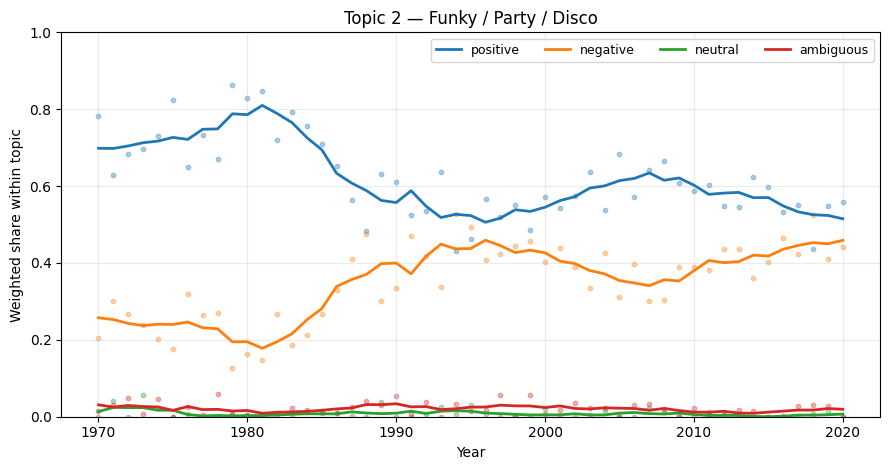

saved: /Users/dariya/Desktop/thesis/outputs/plots_topic_sentiment_trends/topic2_sentiment_trend.png | /Users/dariya/Desktop/thesis/outputs/topic2_sentiment_yearly.csv


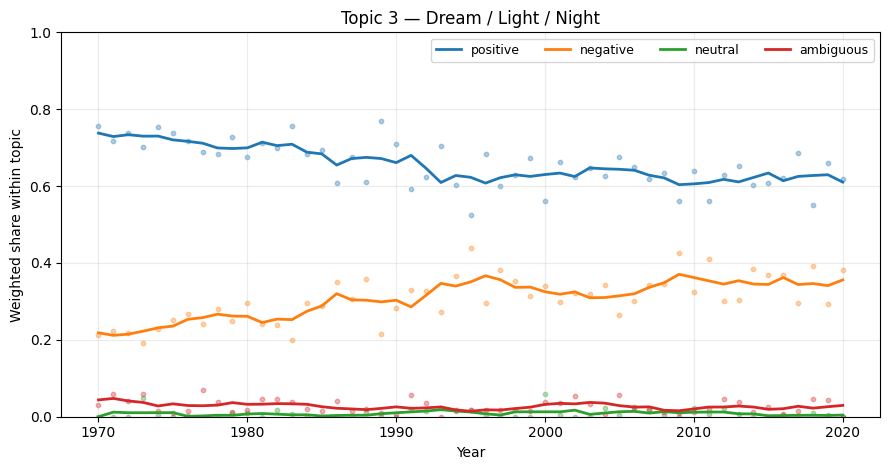

saved: /Users/dariya/Desktop/thesis/outputs/plots_topic_sentiment_trends/topic3_sentiment_trend.png | /Users/dariya/Desktop/thesis/outputs/topic3_sentiment_yearly.csv


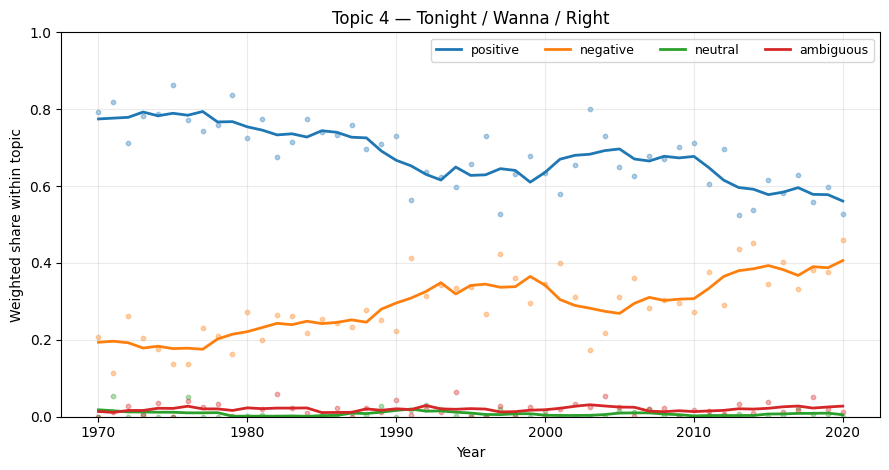

saved: /Users/dariya/Desktop/thesis/outputs/plots_topic_sentiment_trends/topic4_sentiment_trend.png | /Users/dariya/Desktop/thesis/outputs/topic4_sentiment_yearly.csv


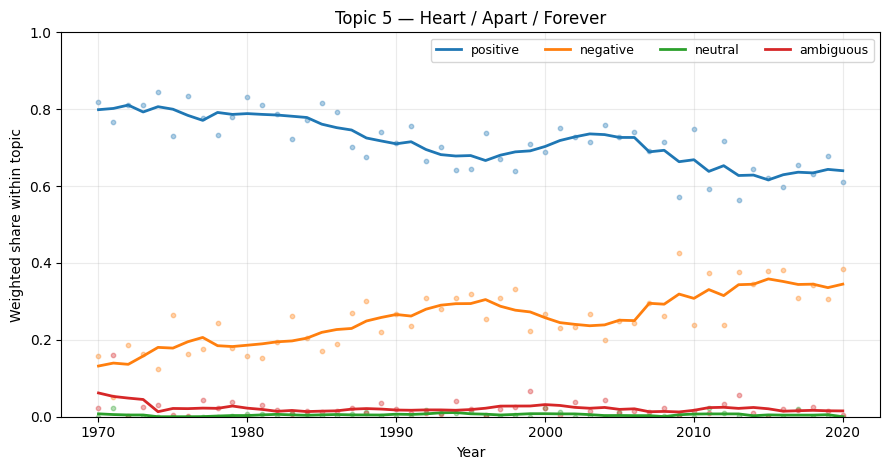

saved: /Users/dariya/Desktop/thesis/outputs/plots_topic_sentiment_trends/topic5_sentiment_trend.png | /Users/dariya/Desktop/thesis/outputs/topic5_sentiment_yearly.csv


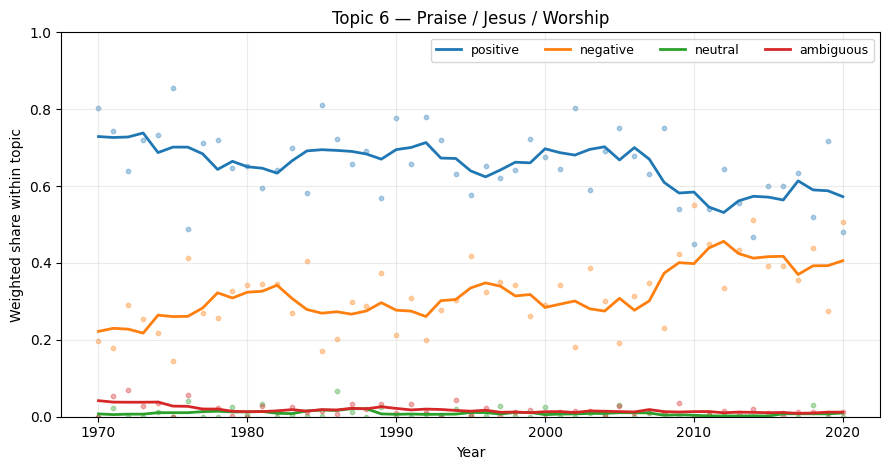

saved: /Users/dariya/Desktop/thesis/outputs/plots_topic_sentiment_trends/topic6_sentiment_trend.png | /Users/dariya/Desktop/thesis/outputs/topic6_sentiment_yearly.csv


In [ ]:
# ==== Topic × Sentiment: yearly trends per topic (0..6) ====
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import pyarrow.dataset as ds
from nltk.sentiment import SentimentIntensityAnalyzer

BASE = Path.home() / "Desktop" / "thesis"
OUT  = BASE / "outputs"
OUT.mkdir(parents=True, exist_ok=True)
PLOTS = OUT / "plots_topic_sentiment_trends"
PLOTS.mkdir(parents=True, exist_ok=True)

# ---------- 1) Read topics (nmf_doc_topics.csv) ----------
topics_csv = OUT / "nmf_doc_topics.csv"
T = pd.read_csv(topics_csv)

# sanity: find topic columns 0..6
topic_cols = [c for c in T.columns if c.startswith("topic_")]
topic_cols = sorted(topic_cols, key=lambda s: int(s.split("_")[1]))
if len(topic_cols) < 7:
    print(f"⚠️ В файле {topics_csv.name} всего {len(topic_cols)} тем. Будем строить по имеющимся.")
T["year"] = pd.to_numeric(T.get("year", np.nan), errors="coerce")
T = T.dropna(subset=["year"]).copy()
T["year"] = T["year"].astype(int)

# ---------- 2) Read lyrics text from normalized layers and compute sentiment ----------
# We avoid old parquet->EA issues: read via pyarrow.dataset and pick any text column present
norm_parq = OUT / "lyrics_normalized_layers.parquet"
dset = ds.dataset(str(norm_parq), format="parquet")
names = set(dset.schema.names)
text_col = next((c for c in ["lyrics_cleanest","lyrics_clean","lyrics","doc_text"] if c in names), None)
need = ["song_id","year", text_col]
for col in need:
    if col is None or col not in names:
        raise RuntimeError(f"В {norm_parq.name} нет нужной колонки: {col}")
acc = {c: [] for c in need}
for b in dset.to_batches(columns=need):
    sch = b.schema
    for c in need:
        acc[c].extend(b.column(sch.get_field_index(c)).to_pylist())
S = pd.DataFrame(acc)
S["year"] = pd.to_numeric(S["year"], errors="coerce")
S = S.dropna(subset=["year"]).copy()
S["year"] = S["year"].astype(int)

# VADER → 4 класса, как раньше
sia = SentimentIntensityAnalyzer()
def vader4(text: str) -> str:
    c = sia.polarity_scores(str(text) if text is not None else "").get("compound", 0.0)
    if c >= 0.2:   return "positive"
    if c <= -0.2:  return "negative"
    return "neutral" if abs(c) < 0.05 else "ambiguous"

S["sentiment"] = S[text_col].map(vader4)
S = S[["song_id","year","sentiment"]]

# ---------- 3) Merge by song_id ----------
if "song_id" not in T.columns:
    raise RuntimeError("В nmf_doc_topics.csv нет song_id — нужно пересохранить таблицу тем с song_id.")
DF = T.merge(S, on=["song_id","year"], how="inner")
print(f"Merge ok: {len(DF):,} строк | лет: {DF['year'].min()}–{DF['year'].max()} | темы: {len(topic_cols)}")

# ---------- 4) Годовые доли сентимента внутри каждой темы ----------
# Метод: в каждом году усредняем индикатор сентимента с весами = принадлежность к теме (topic_k).
# То есть это «какой процент positive/negative и т.д. у песен, если выбирать их с вероятностью ∝ весу темы».
sent_classes = ["positive","negative","neutral","ambiguous"]

def yearly_weighted_shares_for_topic(df, topic_col):
    d = df.copy()
    d["w"] = d[topic_col].astype(float).clip(lower=0)
    out_rows = []
    for year, g in d.groupby("year"):
        denom = float(g["w"].sum())
        if denom <= 0:
            row = {"year": int(year), **{s: np.nan for s in sent_classes}}
        else:
            row = {"year": int(year)}
            for s in sent_classes:
                row[s] = float((g["sentiment"].eq(s) * g["w"]).sum()) / denom
        out_rows.append(row)
    res = pd.DataFrame(out_rows).sort_values("year")
    # сгладим 5-летним окном (по желанию)
    for s in sent_classes:
        res[f"{s}_roll5"] = res[s].rolling(5, center=True, min_periods=1).mean()
    return res

# ---------- 5) Плоты и сохранение ----------
def plot_topic_trend(k, label=None):
    col = f"topic_{k}"
    if col not in DF.columns: 
        print(f"skip {k}: нет {col}"); return
    Y = yearly_weighted_shares_for_topic(DF, col)
    # CSV
    csv_path = OUT / f"topic{k}_sentiment_yearly.csv"
    Y.to_csv(csv_path, index=False)
    # Plot
    plt.figure(figsize=(9,4.8))
    for s in sent_classes:
        plt.plot(Y["year"], Y[f"{s}_roll5"], label=s, linewidth=2)
        plt.scatter(Y["year"], Y[s], s=10, alpha=.35)  # несглаженные точки
    ttl = f"Topic {k}" + (f" — {label}" if label else "")
    plt.title(ttl)
    plt.xlabel("Year"); plt.ylabel("Weighted share within topic")
    plt.ylim(0,1); plt.grid(alpha=.25); plt.legend(ncol=4, fontsize=9)
    out_png = PLOTS / f"topic{k}_sentiment_trend.png"
    plt.tight_layout(); plt.savefig(out_png, dpi=200); plt.show()
    print("saved:", out_png, "|", csv_path)

# авто-лейблы, если сохранял ранее
labels = None
topics_table = OUT / "nmf_topics_k7.csv"
if topics_table.exists():
    try:
        tmp = pd.read_csv(topics_table)
        if "auto_label" in tmp.columns:
            labels = dict(zip(tmp["topic_id"], tmp["auto_label"]))
    except Exception:
        pass

# запустить для всех обнаруженных тем
for k in range(min(7, len(topic_cols))):
    plot_topic_trend(k, label=(labels.get(k) if labels else None))
